In [ ]:
# !pip install scikit-optimize
# !pip install sktime
# !pip install tensorflow --user
# !pip install statsmodels --user
# !pip install xgboost --user

In [ ]:
# Basic libraries
import os
import random
from collections import defaultdict
from datetime import datetime as dt
import warnings

import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Machine learning libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    mean_squared_error, 
    mean_absolute_error, 
    mean_absolute_percentage_error, 
    r2_score, 
    mean_squared_log_error
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import (
    RandomForestRegressor, 
    GradientBoostingRegressor, 
    ExtraTreesRegressor, 
    AdaBoostRegressor
)
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, DotProduct, WhiteKernel
import xgboost as xgb

# Time series libraries
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_breusch_godfrey, acorr_ljungbox, het_white
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from arch import arch_model
import pmdarima as pm
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import ForecastingGridSearchCV, SlidingWindowSplitter

#Libraries for Statistical Models
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_breusch_godfrey, acorr_ljungbox, het_white
from scipy.stats import jarque_bera
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment

# LightGBM library
import lightgbm as lgb

# Set options
%matplotlib inline
warnings.filterwarnings("ignore")


Functions

In [ ]:
# add date tiem features
def add_datetime_features(df):
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    df_copy = df.copy()
    
    # Extract year, month, and day information
    df_copy['year'] = df_copy.index.year
    df_copy['month'] = df_copy.index.month
    df_copy['day'] = df_copy.index.day
    df_copy['weekday'] = df_copy.index.weekday
    
    return df_copy

def generate_lagged_features(df, var, max_lag):
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    ts_data = df.copy()
    for t in range(1, max_lag + 1):
        ts_data[var + '_lag' + str(t)] = ts_data[var].shift(t, freq='1D')
    # print(ts_data.head())
    # print(ts_data.tail())
    # print(ts_data.shape)
    ts_data.dropna(inplace=True)

    return ts_data

# def prepare_time_series_data(df, var, max_lag):
#     # Generate lagged features
#     lagged_data = generate_lagged_features(df, var, max_lag)
    
#     # Add datetime features
#     if not isinstance(lagged_data.index, pd.DatetimeIndex):
#         lagged_data.index = pd.to_datetime(lagged_data.index)
#     transformed_data = add_datetime_features(lagged_data)
    
#     return transformed_data

def extract_column(df, column_name):
    extracted_column = df[column_name]
    remaining_df = df.drop(column_name, axis=1)
    return remaining_df, extracted_column

# def scale_data(train_data, test_data):
#     scaler = MinMaxScaler()
#     train_scaled = scaler.fit_transform(train_data)
#     test_scaled = scaler.transform(test_data)
#     return train_scaled, test_scaled, scaler

# def scale_data(train_data, test_data, target_column):
#     scaler_X = MinMaxScaler()
#     scaler_Y = MinMaxScaler()
    
#     train_X = train_data.drop(target_column, axis=1)
#     train_Y = train_data[[target_column]]
    
#     test_X = test_data.drop(target_column, axis=1)
#     test_Y = test_data[[target_column]]
    
#     train_X_scaled = scaler_X.fit_transform(train_X)
#     train_Y_scaled = scaler_Y.fit_transform(train_Y)
    
#     test_X_scaled = scaler_X.transform(test_X)
#     test_Y_scaled = scaler_Y.transform(test_Y)
    
#     train_data_scaled = np.concatenate((train_X_scaled, train_Y_scaled), axis=1)
#     test_data_scaled = np.concatenate((test_X_scaled, test_Y_scaled), axis=1)
    
#     return train_data_scaled, test_data_scaled, scaler_X, scaler_Y


def scale_data(train_data, test_data, target_column):
    # scaler_X = MinMaxScaler()
    # scaler_Y = MinMaxScaler()
    # scaler_X = StandardScaler()
    # scaler_Y = StandardScaler() 
    scaler_X = RobustScaler()
    scaler_Y = RobustScaler()   
    
    train_X = train_data.drop(target_column, axis=1)
    # print(train_X)
    # train_X = train_data
    train_Y = train_data[[target_column]]
    # print(train_Y)
    test_X = test_data.drop(target_column, axis=1)
    # test_X = test_data
    test_Y = test_data[[target_column]]
    # print('xscaled')
    train_X_scaled = scaler_X.fit_transform(train_X)
    # print(train_X_scaled.shape)
    train_Y_scaled = scaler_Y.fit_transform(train_Y)
    # print('yscaled')
    # print(train_Y_scaled.shape)
    test_X_scaled = scaler_X.transform(test_X)
    test_Y_scaled = scaler_Y.transform(test_Y)
    
    # train_data_scaled = np.concatenate((train_X_scaled, train_Y_scaled), axis=1)
    # test_data_scaled = np.concatenate((test_X_scaled, test_Y_scaled), axis=1)
    train_data_scaled = pd.concat([pd.DataFrame(train_X_scaled, columns=train_X.columns, index=train_X.index),
                                pd.DataFrame(train_Y_scaled, columns=train_Y.columns, index=train_Y.index)], axis=1)
    test_data_scaled = pd.concat([pd.DataFrame(test_X_scaled, columns=test_X.columns, index=test_X.index),
                                pd.DataFrame(test_Y_scaled, columns=test_Y.columns, index=test_Y.index)], axis=1)


    # print(train_data_scaled.shape)
    return train_data_scaled, test_data_scaled, scaler_X, scaler_Y


def unscale_data(pred, actual, scaler):
    pred = scaler.inverse_transform(pred)
    actual = scaler.inverse_transform(actual)
    return pred, actual

In [ ]:
def standardize_series(series):
    return StandardScaler().fit_transform(series.values.reshape(-1, 1))

def apply_dbscan_clustering(series_standardized, eps=0.5, min_samples=2):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    return dbscan.fit_predict(series_standardized)

def extract_outliers_from_clusters(series, clusters):
    """Identify the outliers (cluster label -1 indicates an outlier)"""
    return series[clusters == -1]

def cluster_based_outlier_detection(series):
    series_standardized = standardize_series(series)
    clusters = apply_dbscan_clustering(series_standardized, eps=0.15)
    outliers = extract_outliers_from_clusters(series, clusters)
    print('Outliers shape: {}'.format(outliers.shape))
    # Create a DataFrame with the same index as the original series
    outliers_df = pd.DataFrame(index=series.index)
    outliers_df['outliers'] = 0
    outliers_df.loc[outliers.index, 'outliers'] = 1

    return outliers_df
    
# def prepare_time_series_data(df, var, max_lag, detect_outliers=False):
#     # Generate lagged features
#     lagged_data = generate_lagged_features(df, var, max_lag)
#     # print('Lagged data shape: {}'.format(lagged_data.shape))
    
#     # Add outlier features if detect_outliers is True
#     if detect_outliers:
#         series = df[var].pow(2)
#         series.dropna(inplace=True)  
#         # print('Series shape: {}'.format(series.shape))
#         outliers_df = cluster_based_outlier_detection(series)
#         # print('Outliers DataFrame shape: {}'.format(outliers_df.shape))
#         lagged_outliers = generate_lagged_features(outliers_df, 'outliers', max_lag)
#         # print('Lagged outliers shape: {}'.format(lagged_outliers.shape))
#         lagged_data = lagged_data.merge(lagged_outliers, left_index=True, right_index=True)
#         # print('Lagged data shape: {}'.format(lagged_data.shape))

#     # Add datetime features
#     if not isinstance(lagged_data.index, pd.DatetimeIndex):
#         lagged_data.index = pd.to_datetime(lagged_data.index)
#     transformed_data = add_datetime_features(lagged_data)

#     # Drop rows with missing values
#     transformed_data.dropna(inplace=True)

#     return transformed_data
def prepare_time_series_data(df, var, max_lag, detect_outliers=False):
    # Generate lagged features
    lagged_data = generate_lagged_features(df, var, max_lag)
    # print('Lagged data shape: {}'.format(lagged_data.shape))
    
    # Add outlier features if detect_outliers is True
    if detect_outliers:
        series = df[var].pow(2)
        series.dropna(inplace=True)  
        # print('Series shape: {}'.format(series.shape))
        outliers_df = cluster_based_outlier_detection(series)
        # print('Outliers DataFrame shape: {}'.format(outliers_df.shape))
        lagged_outliers = generate_lagged_features(outliers_df, 'outliers', max_lag)
        # print('Lagged outliers shape: {}'.format(lagged_outliers.shape))
        lagged_data = lagged_data.merge(lagged_outliers, left_index=True, right_index=True)
        # print('Lagged data shape: {}'.format(lagged_data.shape))

    # Add datetime features
    if not isinstance(lagged_data.index, pd.DatetimeIndex):
        lagged_data.index = pd.to_datetime(lagged_data.index)
    # transformed_data = add_datetime_features(lagged_data)
    transformed_data = lagged_data
    # Drop rows with missing values
    transformed_data.dropna(inplace=True)

    return transformed_data

In [ ]:
def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    # msle = mean_squared_log_error(y_true, y_pred)
    return {
        'rmse': rmse,
    }

def perform_grid_search(model, param_grid, X_train, Y_train, cv):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
        scoring='neg_mean_squared_error',
        verbose=3,
        n_jobs=-1,
    )
    grid_search.fit(X_train, Y_train)
    best_model = grid_search.best_estimator_
    cv_results = grid_search.cv_results_
    mean_score = -np.mean(cv_results['mean_test_score'])
    std_score = np.std(cv_results['mean_test_score'])
    
    # Take the square root of the mean_score and std_score
    rmse_mean = np.sqrt(mean_score)
    rmse_std = np.sqrt(std_score)
    
    return best_model, rmse_mean, rmse_std

def train_best_model(best_model, X_train, Y_train):
    best_model.fit(X_train, Y_train)
    return best_model

def predict(model, X):
    return model.predict(X)

def reshape_and_unscale_predictions(preds, actuals, scaler_Y):
    # Reshape predictions and actual values for unscaling
    preds_reshaped = preds.reshape(-1, 1)
    actuals_reshaped = actuals.values.reshape(-1, 1)

    # Unscale the predictions and actual values
    unscaled_preds, unscaled_actuals = unscale_data(preds_reshaped, actuals_reshaped, scaler_Y)

    # Convert the unscaled predictions and actuals back to pandas Series
    unscaled_preds_series = pd.Series(unscaled_preds.squeeze(), index=actuals.index)
    unscaled_actuals_series = pd.Series(unscaled_actuals.squeeze(), index=actuals.index)

    return unscaled_preds_series, unscaled_actuals_series

    
def create_directory_if_not_exists(directory):
    os.makedirs(directory, exist_ok=True)
    

def save_plots_for_experiment(experiment, hypothesis, model_name, train_or_test, plot_type):
    # Create the necessary directories
    experiment_path = os.path.join(hypothesis, experiment, train_or_test)
    create_directory_if_not_exists(experiment_path)
    
    # Return the save path
    save_path = os.path.join(experiment_path, f"{model_name}_{plot_type}.png")
    return save_path

    
def model_pipeline(model, param_grid, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, model_name,experiment, show_plot=False):
    
    # Perform grid search
    best_model, rmean_error_train, std_error = perform_grid_search(model, param_grid, X_train, Y_train, tscv)
    
    print("\nBest model:", best_model)
    print("\nMean error:", rmean_error_train)
    print("\nStandard error:", std_error)
    
    # Train best model on all training data
    best_model_trained = train_best_model(best_model, X_train, Y_train)
    
    # Predict on train set
    train_preds = predict(best_model_trained, X_train)
    
    # Unscale and plot predictions vs actuals for train set
    unscaled_preds_series, unscaled_actuals_series = reshape_and_unscale_predictions(train_preds, Y_train, scaler_Y)
    save_path = save_plots_for_experiment(experiment, hypothesis, model_name, "train", "predictions_vs_actuals")
    plot_series(unscaled_actuals_series, unscaled_preds_series, title="Unscaled Predictions vs Actual Training Data", save_path=save_path, show_plot=show_plot)

    # Perform residual analysis for train set
    residuals_train = unscaled_actuals_series - unscaled_preds_series
    print("\nResidual analysis for train set:")
    save_path = save_plots_for_experiment(experiment, hypothesis, model_name, "train", "correlogram")
    plot_correlogram(residuals_train, save_path=save_path, show_plot=show_plot)
    save_path = save_plots_for_experiment(experiment, hypothesis, model_name, "train", "homoskedasticity_plot")
    residual_analysis(residuals_train, unscaled_preds_series, save_path=save_path)
    print("\nResiduals squared\n")
    save_path = save_plots_for_experiment(experiment, hypothesis, model_name, "train", "correlogram_squared")
    plot_correlogram(residuals_train.pow(2), save_path=save_path, show_plot=False)
    residual_analysis(residuals_train.pow(2), unscaled_preds_series.pow(2), save_path=None)
    
    # Predict on test set
    test_preds = predict(best_model_trained, X_test)
    rmse_test = np.sqrt(mean_squared_error(Y_test, test_preds))
    print("RMSE:", rmse_test)
    
    # Unscale and plot predictions vs actuals for test set
    unscaled_preds_series, unscaled_actuals_series = reshape_and_unscale_predictions(test_preds, Y_test, scaler_Y)
    save_path = save_plots_for_experiment(experiment, hypothesis, model_name, "test", "predictions_vs_actuals")
    plot_series(unscaled_actuals_series, unscaled_preds_series, title="Unscaled Predictions vs Actual Test Data", save_path=save_path, show_plot=show_plot)

    # Perform residual analysis for test set
    residuals_test = unscaled_actuals_series - unscaled_preds_series
    print("\nResidual analysis for test set:")
    save_path = save_plots_for_experiment(experiment, hypothesis, model_name, "test", "correlogram")
    plot_correlogram(residuals_test, save_path=save_path, show_plot=show_plot)
    save_path = save_plots_for_experiment(experiment, hypothesis, model_name, "test", "homoskedasticity_plot")
    residual_analysis(residuals_test, unscaled_preds_series, save_path=save_path)
    print("\nResiduals squared\n")
    save_path = save_plots_for_experiment(experiment, hypothesis, model_name, "test", "correlogram_squared")
    plot_correlogram(residuals_test.pow(2), title='Residuals Squared', save_path=save_path, show_plot=False)
    residual_analysis(residuals_test.pow(2), unscaled_preds_series.pow(2), save_path=None)

    return best_model_trained , rmean_error_train, rmse_test 

In [ ]:
def plot_series(series1, series2, label1="Actual", label2="Predicted", title="Unscaled Predictions vs Actual Data", save_path=None, show_plot=False):
    fig, ax = plt.subplots()
    ax.plot(series1.index, series1, label=label1)
    ax.plot(series2.index, series2, label=label2, linestyle="--")
    ax.legend()
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.title(title)
    if save_path:
        plt.savefig(save_path)
    plt.close()

def plot_correlogram(x, lags=None, title=None,save_path=None, show_plot=False):
    lags = min(10, int(len(x)/5)) if lags is None else lags
    x = x + np.random.normal(0, 1e-10, len(x)) ## Add noise to avoid non-invertibility
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    
    # Residuals plot
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    
    # Probability plot
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    
    # ACF and PACF plots
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)
    if save_path:
        plt.savefig(save_path)
    plt.close()
    
    
def residual_analysis(residuals, y_pred, save_path=None):
    
    # Check for homoscedasticity
    print("Homoscedasticity scatter plot:")
    plt.scatter(y_pred, residuals)
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.axhline(y=0, color="r", linestyle="--")
    if save_path:
        plt.savefig(save_path)
    plt.close()

    # Perform Ljung-Box test for autocorrelation in residuals
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)  
    print("Ljung-Box test for autocorrelation in residuals:")
    print(lb_test)
    # Assess the p-value of the Ljung-Box test
    p_value = lb_test['lb_pvalue'][10]
    if p_value < 0.05:
        print("The Ljung-Box test suggests that there is autocorrelation in the residuals (p-value < 0.05).")
    else:
        print("The Ljung-Box test suggests that there is no significant autocorrelation in the residuals (p-value >= 0.05).")
    
    # Perform Jarque-Bera test for normality in residuals
    jb_test = jarque_bera(residuals)
    print("\nJarque-Bera test for normality in residuals:")
    if jb_test[1] < 0.05:
        print(f"Test statistic: {jb_test[0]}, p-value: {jb_test[1]}")
        print("The Jarque-Bera test suggests that the residuals are not normally distributed (p-value < 0.05).")
    else:
        print(f"Test statistic: {jb_test[0]}, p-value: {jb_test[1]}")
        print("The Jarque-Bera test suggests that the residuals are normally distributed (p-value >= 0.05).")    
        
def plot_rmse_comparison(results, hypothesis, experiment):
    fig = plt.figure()
    model_names = list(results.keys())
    train_rmse_values = [result['train_rmse'] for result in results.values()]
    test_rmse_values = [result['test_rmse'] for result in results.values()]

    ind = np.arange(len(model_names))  # the x locations for the groups
    width = 0.35  # the width of the bars

    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.bar(ind - width/2, train_rmse_values, width=width, label='Train Error')
    plt.bar(ind + width/2, test_rmse_values, width=width, label='Test Error')
    fig.set_size_inches(15, 8)
    plt.legend()
    ax.set_xticks(ind)
    ax.set_xticklabels(model_names)
    
    # Save the plot
    save_path = save_plots_for_experiment(experiment, hypothesis, "Results", "", "Model_Comparison")
    if save_path:
        plt.savefig(save_path)
    plt.close()
    
def plot_rmse_comparison_hypothesis(hypothesis_results):
    fig, ax = plt.subplots()
    fig.suptitle('Algorithm Comparison')
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_experiments = len(hypothesis_results)
    model_names = list(next(iter(hypothesis_results.values())).keys())
    n_models = len(model_names)
    width = 0.8 / (n_models * 2)  # the width of the bars

    x = np.arange(n_experiments) * (n_models * 2 + 1)  # the x locations for the groups

    for i, (model_name) in enumerate(model_names):
        for j, (experiment, results) in enumerate(hypothesis_results.items()):
            train_rmse = results[model_name]['train_rmse']
            test_rmse = results[model_name]['test_rmse']

            ax.bar(x[j] + i * width * 2, train_rmse, width=width, label=f"{model_name} Train Error",color=colors[i % len(colors)])
            ax.bar(x[j] + i * width * 2 + width, test_rmse, width=width, label=f"{model_name} Test Error",color=colors[i % len(colors)])

    fig.set_size_inches(15, 8)
    plt.legend()
    ax.set_xticks(x + width * (n_models - 1))
    ax.set_xticklabels(hypothesis_results.keys())



    plt.show()
    # Save the plot
    # save_path = save_plots_for_experiment("", hypothesis, "Results", "", "Model_Comparison")
    # if save_path:
    #     plt.savefig(save_path)
    # plt.close()

In [ ]:
def evaluate_rw(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    msle = mean_squared_log_error(y_true, y_pred)

    return {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'mape': mape,
        'r2': r2,
        'msle': msle,
    }

# univaritae
## Simple models for benchmarking
def random_walk_forecast(start_point, forecast_length, return_mean, return_std, index):
    prediction = [start_point]

    for i in range(1, forecast_length):
        next_value = prediction[-1] * (1 + random.normalvariate(mu=return_mean, sigma=return_std))
        prediction.append(next_value)

    return pd.Series(prediction, index=index)

def calculate_benchmark_errors(series):
    mean_returns, std_returns = calculate_returns_stats(series)
    forecast_length = len(series)
    start_point = series[0]
    predictions = random_walk_forecast(start_point, forecast_length, mean_returns, std_returns, series.index)
    # print(predictions)
    evaluation_result = evaluate_rw(series, predictions)
    # Return a dictionary containing the evaluation results for each baseline
    return {
        'Benchmark MAE': evaluation_result['mae'],
        'Benchmark MSE': evaluation_result['mse'],
        'Benchmark RMSE': evaluation_result['rmse'],
        'Benchmark MAPE': evaluation_result['mape'],
        'Benchmark R2': evaluation_result['r2'],
        'Benchmark MSLE': evaluation_result['msle'],
    }

def calculate_returns_stats(time_series):
    # Calculate the returns
    returns = time_series / time_series.shift(1) - 1
    returns = returns.dropna()

    # Calculate mean returns and standard deviation of returns
    mean_returns = returns.mean()
    std_returns = returns.std()

    return mean_returns, std_returns

# multivariate
def random_walk_forecast_multivariate(start_points, forecast_length, return_means, return_stds, index):
    num_variables = len(start_points)
    predictions = [start_points]

    for _ in range(1, forecast_length):
        next_values = [predictions[-1][i] * (1 + random.normalvariate(mu=return_means[i], sigma=return_stds[i])) for i in range(num_variables)]
        predictions.append(next_values)

    # Transpose the list of predictions and convert each variable's predictions to a pandas Series
    predictions_transposed = list(map(list, zip(*predictions)))
    prediction_series = [pd.Series(pred, index=index) for pred in predictions_transposed]

    return prediction_series

def calculate_benchmark_errors_mult(series1, series2):
    mean_returns1, std_returns1 = calculate_returns_stats(series1)
    mean_returns2, std_returns2 = calculate_returns_stats(series2)
    
    forecast_length = len(series1)
    start_points = [series1[0], series2[0]]
    return_means = [mean_returns1, mean_returns2]
    return_stds = [std_returns1, std_returns2]
    
    predictions = random_walk_forecast_multivariate(start_points, forecast_length, return_means, return_stds, series1.index)
    
    evaluation_result1 = evaluate_rw(series1, predictions[0])
    evaluation_result2 = evaluate_rw(series2, predictions[1])
    # plot_time_series(series1, predictions[0])
    # plot_time_series(series2, predictions[1])
    
    return {
        'Series1 Benchmark MAE': evaluation_result1['mae'],
        'Series1 Benchmark MSE': evaluation_result1['mse'],
        'Series1 Benchmark RMSE': evaluation_result1['rmse'],
        'Series1 Benchmark MAPE': evaluation_result1['mape'],
        'Series1 Benchmark R2': evaluation_result1['r2'],
        'Series1 Benchmark MSLE': evaluation_result1['msle'],
        'Series2 Benchmark MAE': evaluation_result2['mae'],
        'Series2 Benchmark MSE': evaluation_result2['mse'],
        'Series2 Benchmark RMSE': evaluation_result2['rmse'],
        'Series2 Benchmark MAPE': evaluation_result2['mape'],
        'Series2 Benchmark R2': evaluation_result2['r2'],
        'Series2 Benchmark MSLE': evaluation_result2['msle'],
    }
    
def monte_carlo_simulation(series, n_trials=10000):
    # Initialize a dictionary to store the accumulated evaluation results
    accumulated_results = {
        'Benchmark MAE': 0,
        'Benchmark MSE': 0,
        'Benchmark RMSE': 0,
        'Benchmark MAPE': 0,
        'Benchmark R2': 0,
        'Benchmark MSLE': 0,
    }

    for _ in range(n_trials):
        # Calculate benchmark errors for this trial
        trial_results = calculate_benchmark_errors(series)

        # Accumulate the results of this trial
        for key in accumulated_results.keys():
            accumulated_results[key] += trial_results[key]

    # Average the accumulated results over the number of trials
    for key in accumulated_results.keys():
        accumulated_results[key] /= n_trials

    return accumulated_results
    
def monte_carlo_simulation_mult(series1, series2, n_trials=10000):
    # Initialize a dictionary to store the accumulated evaluation results
    accumulated_results = {
        'Series1 Benchmark MAE': 0,
        'Series1 Benchmark MSE': 0,
        'Series1 Benchmark RMSE': 0,
        'Series1 Benchmark MAPE': 0,
        'Series1 Benchmark R2': 0,
        'Series1 Benchmark MSLE': 0,
        'Series2 Benchmark MAE': 0,
        'Series2 Benchmark MSE': 0,
        'Series2 Benchmark RMSE': 0,
        'Series2 Benchmark MAPE': 0,
        'Series2 Benchmark R2': 0,
        'Series2 Benchmark MSLE': 0,
    }

    for _ in range(n_trials):
        # Calculate benchmark errors for this trial
        trial_results = calculate_benchmark_errors_mult(series1, series2)

        # Accumulate the results of this trial
        for key in accumulated_results.keys():
            accumulated_results[key] += trial_results[key]

    # Average the accumulated results over the number of trials
    for key in accumulated_results.keys():
        accumulated_results[key] /= n_trials

    return accumulated_results
    
    
import matplotlib.pyplot as plt
import numpy as np



In [ ]:
models_and_param_grids = [
    {
        'model': DecisionTreeRegressor(random_state=42),
        'param_grid': {
            'max_depth': [None, 10, 20, 30,50],
            'min_samples_split': [2, 5, 10],
            'max_features': ['auto'],
            'min_samples_leaf': [1, 3, 5, 10]
        },
        'model_name': 'CART',
    },
    # {
    #     'model': MLPRegressor(random_state=42),
    #     'param_grid': {
    #         'hidden_layer_sizes': [(50,), (100,), (50, 50),(100, 100), (50, 50, 50), (100, 100, 100), (50, 50, 50, 50), (100, 100, 100, 100)],
    #         'activation': ['tanh', 'relu', 'logistic'],
    #         'solver': ['sgd'],
    #         'alpha': [0.00005, 0.0005, 0.005],
    #         'early_stopping': [True],
    #         'max_iter': [600],
    #         'shuffle': [False],
    #     },
    #     'model_name': 'MLP',
    # },
    {
        'model': KNeighborsRegressor(),
        'param_grid': {
            'n_neighbors': [3, 5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto'],
            'leaf_size': [10, 30, 50],
        },
        'model_name': 'KNN',
    },
    # {
    #     'model': GaussianProcessRegressor(random_state=42),
    #     'param_grid': {
    #         'kernel': [RBF(), DotProduct()+ WhiteKernel()],
    #         'alpha': [1e-10, 1e-5, 1e-2, 1],
    #         'n_restarts_optimizer': [0, 1, 3],
    #     },
    #     'model_name': 'GPR',
    # },
    {
        'model': lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=-1, random_state=42),
        'param_grid': {
            'lgbmregressor__n_estimators': [100,200],
            'lgbmregressor__learning_rate': [0.01],
            'lgbmregressor__max_depth': [5, 10, 20],
            'lgbmregressor__num_leaves': [35, 50],
        },
        'model_name': 'GBR',
    },
        {
        'model': xgb.XGBRegressor(random_state=42),
        'param_grid': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 4, 5],
            'min_child_weight': [1, 3, 5],
        },
        'model_name': 'XGB',
    },
    {
        'model': RandomForestRegressor(random_state=42),
        'param_grid': {
            'n_estimators': [10, 50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'max_features': ['auto'],
        },
        'model_name': 'RF',
    },
]


In [ ]:
def process_data(train_data, test_data, lags, input_column, target_column, detect_outliers = False):
    # Create new dataframes with input and target columns
    input_train = train_data[[input_column]]
    input_test = test_data[[input_column]]
    input_train.columns = ['input']
    input_test.columns = ['input']
    target_train = train_data[[target_column]]
    target_test = test_data[[target_column]]
    target_train.columns = ['target']
    target_test.columns = ['target']

    train_data = pd.concat([input_train, target_train], axis=1)
    test_data = pd.concat([input_test, target_test], axis=1)
    train_data_datetime = add_datetime_features(train_data)
    test_data_datetime = add_datetime_features(test_data)

    # Scale the data
    train_data_scaled, test_data_scaled, scaler_X, scaler_Y = scale_data(train_data_datetime, test_data_datetime, 'target')

    # Prepare time series data
    train_transformed = prepare_time_series_data(train_data_scaled, 'input', lags, detect_outliers=detect_outliers)
    test_transformed = prepare_time_series_data(test_data_scaled, 'input', lags, detect_outliers=detect_outliers)

    # Drop the input column
    train_transformed = train_transformed.drop('input', axis=1)
    test_transformed = test_transformed.drop('input', axis=1)

    # Extract X and Y
    X_train, Y_train = extract_column(train_transformed, 'target')
    X_test, Y_test = extract_column(test_transformed, 'target')

    return X_train, Y_train, X_test, Y_test, scaler_X, scaler_Y

In [ ]:
def run_experiment(models_and_param_grids, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, experiment):
    results = {}

    for model_info in models_and_param_grids:
        model = model_info['model']
        param_grid = model_info['param_grid']
        model_name = model_info['model_name']
        print(f"\nTraining {model_name} model...")

        best_model_trained, train_rmse, test_rmse = model_pipeline(
            model, param_grid, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, model_name, experiment=experiment
        )

        results[model_name] = {
            'model': best_model_trained,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
        }

    print("\nResults:")
    for model_name, model_results in results.items():
        print(
            f"{model_name}: Train RMSE: {model_results['train_rmse']:.4f}, Test RMSE: {model_results['test_rmse']:.4f}"
        )

    plot_rmse_comparison(results, hypothesis, experiment=experiment)

    return results

In [ ]:
def load_raw_data(filename):
    raw_df = pd.read_csv(filename, header=None)
    raw_df.columns = ['datetime', 'ts1', 'ts2']
    raw_df['datetime'] = pd.to_datetime(raw_df['datetime'] - 719529, unit='d').round('s')
    raw_df.set_index('datetime', inplace=True)
    raw_df.dropna(inplace=True)
    return raw_df

def calculate_log_returns(df):
    rt = np.log(df / df.shift(1))
    rt.dropna(inplace=True)
    return rt

def load_clean_data(filename):
    clean_df = pd.read_csv(filename)
    clean_df.columns = ['datetime', 'ts1', 'ts2']
    clean_df.set_index('datetime', inplace=True)
    clean_df.index = pd.to_datetime(clean_df.index)
    return clean_df    

In [ ]:
def split_series(series, split_date):
    series.index = pd.to_datetime(series.index)
    split_date = pd.Timestamp(split_date)
    
    before_split = series.loc[series.index <= split_date]
    after_split = series.loc[series.index > split_date]
    
    return before_split, after_split

In [ ]:
# def load_raw_data(filename):
#     raw_df = pd.read_csv(filename, header=None)
#     raw_df.columns = ['datetime', 'ts1', 'ts2']
#     raw_df['datetime'] = pd.to_datetime(raw_df['datetime'] - 719529, unit='d').round('s')
#     raw_df.set_index('datetime', inplace=True)
#     raw_df.dropna(inplace=True)
#     return raw_df

# def calculate_log_returns(df):
#     rt = np.log(df / df.shift(1))
#     rt.dropna(inplace=True)
#     return rt

# #load raw data
# df = load_raw_data("Test_data.csv")
# #calcualte log returns
# raw_rt = calculate_log_returns(df)
# raw_rt_daily = raw_rt.resample('D').mean()

In [ ]:
#   def load_clean_data(filename):
#     clean_df = pd.read_csv(filename)
#     clean_df.columns = ['datetime', 'ts1', 'ts2']
#     clean_df.set_index('datetime', inplace=True)
#     clean_df.index = pd.to_datetime(clean_df.index)
#     return clean_df     

# df = load_clean_data('interpolate_clean_df.csv')
# #calcualte log returns
# imp_rt = calculate_log_returns(df)
# imp_rt_daily = imp_rt.resample('D').mean()


# rt_d = pd.read_csv('rt_daily.csv')
# rt_d.columns = ['datetime', 'ts1', 'ts2']
# rt_d.set_index('datetime', inplace = True)
# rt_d

In [ ]:
#load raw data
df = load_raw_data("Test_data.csv")
#calcualte log returns
raw_rt = calculate_log_returns(df)
raw_rt_daily = raw_rt.resample('H').mean()

df = load_clean_data('interpolate_clean_df.csv')
#calcualte log returns
imp_rt = calculate_log_returns(df)
imp_rt_daily = imp_rt.resample('H').mean()

# prerpare train and test experiments
train_imp, test_imp = split_series(imp_rt_daily, '2011-12-31')
train_raw, test_raw = split_series(raw_rt_daily, '2011-12-31')

test_size = 24 
n_splits = 30
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
lags = 4

Experiments

In [27]:
#H1
hypothesis = 'H1'
hypothesis_results1 = {}
# EX1
X_train, Y_train, X_test, Y_test,scaler_X, scaler_Y = process_data(train_raw, test_raw, lags, detect_outliers=False, input_column='ts1', target_column='ts1')
experiment = 'Raw_no_outliers'+"_split_"+str(n_splits)+"_test_size_"+str(test_size)
results = run_experiment(models_and_param_grids, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results1[experiment] = results

# EX2
X_train, Y_train, X_test, Y_test,scaler_X, scaler_Y = process_data(train_raw, test_raw, lags, detect_outliers=True, input_column='ts1', target_column='ts1')
experiment = 'Raw_outliers'+"_split_"+str(n_splits)+"_test_size_"+str(test_size)
results = run_experiment(models_and_param_grids, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results1[experiment] = results

# EX3
X_train, Y_train, X_test, Y_test,scaler_X, scaler_Y = process_data(train_imp, test_raw, lags, detect_outliers=False, input_column='ts1', target_column='ts1')
experiment = 'Imputed_no_outliers'+"_split_"+str(n_splits)+"_test_size_"+str(test_size)
results = run_experiment(models_and_param_grids, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results1[experiment] = results

# EX4 
X_train, Y_train, X_test, Y_test,scaler_X, scaler_Y = process_data(train_imp, test_raw, lags, detect_outliers=True, input_column='ts1', target_column='ts1')
experiment = 'Impute_outliers'+"_split_"+str(n_splits)+"_test_size_"+str(test_size)
results = run_experiment(models_and_param_grids, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results1[experiment] = results

# Usage example:
# plot_rmse_comparison_hypothesis(hypothesis_results1)


Training CART model...
Fitting 30 folds for each of 60 candidates, totalling 1800 fits

Best model: DecisionTreeRegressor(max_depth=10, max_features='auto', min_samples_leaf=3,
                      random_state=42)

Mean error: 2.384197162689461

Standard error: 1.1403385421588996

Residual analysis for train set:
Homoscedasticity scatter plot:
Ljung-Box test for autocorrelation in residuals:
      lb_stat  lb_pvalue
10  43.760552   0.000004
The Ljung-Box test suggests that there is autocorrelation in the residuals (p-value < 0.05).

Jarque-Bera test for normality in residuals:
Test statistic: 57778.10229459544, p-value: 0.0
The Jarque-Bera test suggests that the residuals are not normally distributed (p-value < 0.05).

Residuals squared

Homoscedasticity scatter plot:
Ljung-Box test for autocorrelation in residuals:
       lb_stat     lb_pvalue
10  124.705596  5.598072e-22
The Ljung-Box test suggests that there is autocorrelation in the residuals (p-value < 0.05).

Jarque-Bera test 

In [28]:
#H1
hypothesis = 'H2'
hypothesis_results2 = {}
# EX1
X_train, Y_train, X_test, Y_test,scaler_X, scaler_Y = process_data(train_raw, test_raw, lags, detect_outliers=False, input_column='ts2', target_column='ts2')
experiment = 'Raw_no_outliers'+"_split_"+str(n_splits)+"_test_size_"+str(test_size)
results = run_experiment(models_and_param_grids, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results2[experiment] = results

# EX2
X_train, Y_train, X_test, Y_test,scaler_X, scaler_Y = process_data(train_raw, test_raw, lags, detect_outliers=True, input_column='ts2', target_column='ts2')
experiment = 'Raw_outliers'+"_split_"+str(n_splits)+"_test_size_"+str(test_size)
results = run_experiment(models_and_param_grids, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results2[experiment] = results

# EX3
X_train, Y_train, X_test, Y_test,scaler_X, scaler_Y = process_data(train_imp, test_raw, lags, detect_outliers=False, input_column='ts2', target_column='ts2')
experiment = 'Imputed_no_outliers'+"_split_"+str(n_splits)+"_test_size_"+str(test_size)
results = run_experiment(models_and_param_grids, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results2[experiment] = results

# EX4 
X_train, Y_train, X_test, Y_test,scaler_X, scaler_Y = process_data(train_imp, test_raw, lags, detect_outliers=True, input_column='ts2', target_column='ts2')
experiment = 'Impute_outliers'+"_split_"+str(n_splits)+"_test_size_"+str(test_size)
results = run_experiment(models_and_param_grids, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results2[experiment] = results

# Usage example:
# plot_rmse_comparison_hypothesis(hypothesis_results2)


Training CART model...
Fitting 30 folds for each of 60 candidates, totalling 1800 fits

Best model: DecisionTreeRegressor(max_depth=20, max_features='auto', random_state=42)

Mean error: 1.8454774841547994

Standard error: 0.9699597220109537

Residual analysis for train set:
Homoscedasticity scatter plot:
Ljung-Box test for autocorrelation in residuals:
      lb_stat  lb_pvalue
10  21.467738   0.018058
The Ljung-Box test suggests that there is autocorrelation in the residuals (p-value < 0.05).

Jarque-Bera test for normality in residuals:
Test statistic: 121460.3115668197, p-value: 0.0
The Jarque-Bera test suggests that the residuals are not normally distributed (p-value < 0.05).

Residuals squared

Homoscedasticity scatter plot:
Ljung-Box test for autocorrelation in residuals:
      lb_stat  lb_pvalue
10  29.472246   0.001044
The Ljung-Box test suggests that there is autocorrelation in the residuals (p-value < 0.05).

Jarque-Bera test for normality in residuals:
Test statistic: 17002

In [29]:
#H1
hypothesis = 'H3'
hypothesis_results3 = {}
# EX1
X_train, Y_train, X_test, Y_test,scaler_X, scaler_Y = process_data(train_raw, test_raw, lags, detect_outliers=False, input_column='ts1', target_column='ts2')
experiment = 'Raw_no_outliers'+"_split_"+str(n_splits)+"_test_size_"+str(test_size)
results = run_experiment(models_and_param_grids, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results3[experiment] = results

# EX2
X_train, Y_train, X_test, Y_test,scaler_X, scaler_Y = process_data(train_raw, test_raw, lags, detect_outliers=True, input_column='ts1', target_column='ts2')
experiment = 'Raw_outliers'+"_split_"+str(n_splits)+"_test_size_"+str(test_size)
results = run_experiment(models_and_param_grids, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results3[experiment] = results

# EX3
X_train, Y_train, X_test, Y_test,scaler_X, scaler_Y = process_data(train_imp, test_raw, lags, detect_outliers=False, input_column='ts1', target_column='ts2')
experiment = 'Imputed_no_outliers'+"_split_"+str(n_splits)+"_test_size_"+str(test_size)
results = run_experiment(models_and_param_grids, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results3[experiment] = results

# EX4 
X_train, Y_train, X_test, Y_test,scaler_X, scaler_Y = process_data(train_imp, test_raw, lags, detect_outliers=True, input_column='ts1', target_column='ts2')
experiment = 'Impute_outliers'+"_split_"+str(n_splits)+"_test_size_"+str(test_size)
results = run_experiment(models_and_param_grids, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results3[experiment] = results

# Usage example:
# plot_rmse_comparison_hypothesis(hypothesis_results3)


Training CART model...
Fitting 30 folds for each of 60 candidates, totalling 1800 fits

Best model: DecisionTreeRegressor(max_depth=10, max_features='auto', min_samples_leaf=10,
                      random_state=42)

Mean error: 2.252568836235584

Standard error: 1.28369802174403

Residual analysis for train set:
Homoscedasticity scatter plot:
Ljung-Box test for autocorrelation in residuals:
      lb_stat  lb_pvalue
10  17.798998    0.05845
The Ljung-Box test suggests that there is no significant autocorrelation in the residuals (p-value >= 0.05).

Jarque-Bera test for normality in residuals:
Test statistic: 2893513.411285128, p-value: 0.0
The Jarque-Bera test suggests that the residuals are not normally distributed (p-value < 0.05).

Residuals squared

Homoscedasticity scatter plot:
Ljung-Box test for autocorrelation in residuals:
       lb_stat     lb_pvalue
10  226.401386  4.877863e-43
The Ljung-Box test suggests that there is autocorrelation in the residuals (p-value < 0.05).

Ja

In [30]:
#H1
hypothesis = 'H4'
hypothesis_results4 = {}
# EX1
X_train, Y_train, X_test, Y_test,scaler_X, scaler_Y = process_data(train_raw, test_raw, lags, detect_outliers=False, input_column='ts2', target_column='ts1')
experiment = 'Raw_no_outliers'+"_split_"+str(n_splits)+"_test_size_"+str(test_size)
results = run_experiment(models_and_param_grids, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results4[experiment] = results

# EX2
X_train, Y_train, X_test, Y_test,scaler_X, scaler_Y = process_data(train_raw, test_raw, lags, detect_outliers=True, input_column='ts2', target_column='ts1')
experiment = 'Raw_outliers'+"_split_"+str(n_splits)+"_test_size_"+str(test_size)
results = run_experiment(models_and_param_grids, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results4[experiment] = results

# EX3
X_train, Y_train, X_test, Y_test,scaler_X, scaler_Y = process_data(train_imp, test_raw, lags, detect_outliers=False, input_column='ts2', target_column='ts1')
experiment = 'Imputed_no_outliers'+"_split_"+str(n_splits)+"_test_size_"+str(test_size)
results = run_experiment(models_and_param_grids, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results4[experiment] = results

# EX4 
X_train, Y_train, X_test, Y_test,scaler_X, scaler_Y = process_data(train_imp, test_raw, lags, detect_outliers=True, input_column='ts2', target_column='ts1')
experiment = 'Impute_outliers'+"_split_"+str(n_splits)+"_test_size_"+str(test_size)
results = run_experiment(models_and_param_grids, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results4[experiment] = results

# Usage example:
# plot_rmse_comparison_hypothesis(hypothesis_results4)


Training CART model...
Fitting 30 folds for each of 60 candidates, totalling 1800 fits

Best model: DecisionTreeRegressor(max_depth=10, max_features='auto', random_state=42)

Mean error: 2.253939707875112

Standard error: 0.9237848297365292

Residual analysis for train set:
Homoscedasticity scatter plot:
Ljung-Box test for autocorrelation in residuals:
      lb_stat  lb_pvalue
10  46.253357   0.000001
The Ljung-Box test suggests that there is autocorrelation in the residuals (p-value < 0.05).

Jarque-Bera test for normality in residuals:
Test statistic: 91605.11619700801, p-value: 0.0
The Jarque-Bera test suggests that the residuals are not normally distributed (p-value < 0.05).

Residuals squared

Homoscedasticity scatter plot:
Ljung-Box test for autocorrelation in residuals:
    lb_stat  lb_pvalue
10  29.1544   0.001176
The Ljung-Box test suggests that there is autocorrelation in the residuals (p-value < 0.05).

Jarque-Bera test for normality in residuals:
Test statistic: 66332548.9

Benchmark

In [47]:
hypothesis_results4

{'Raw_no_outliers_split_30_test_size_14': {'CART': {'model': DecisionTreeRegressor(max_depth=10, max_features='auto', random_state=42),
   'train_rmse': 2.253939707875112,
   'test_rmse': 1.4364364787969104},
  'KNN': {'model': KNeighborsRegressor(leaf_size=10, n_neighbors=11),
   'train_rmse': 2.1807949688831396,
   'test_rmse': 1.4585087427408832},
  'GBR': {'model': LGBMRegressor(lgbmregressor__learning_rate=0.01, lgbmregressor__max_depth=5,
                 lgbmregressor__n_estimators=100, lgbmregressor__num_leaves=35,
                 random_state=42),
   'train_rmse': 2.0736526022366095,
   'test_rmse': 1.42330209165384},
  'XGB': {'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, gpu_id=None, grow_policy=None, importance_type=

In [41]:
def plot_rmse_experiment_comparison(experiment_results):
    fig, ax = plt.subplots()
    fig.suptitle('Algorithm Comparison')
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_experiments = len(experiment_results)
    model_names = list(next(iter(experiment_results.values())).keys())
    n_models = len(model_names)
    width = 0.8 / (n_models * 2)  # the width of the bars

    x = np.arange(n_experiments) * (n_models * 2 + 1)  # the x locations for the groups

    for i, (model_name) in enumerate(model_names):
        for j, (experiment, results) in enumerate(experiment_results.items()):
            train_rmse = results[model_name]['train_rmse']
            test_rmse = results[model_name]['test_rmse']

            ax.bar(x[j] + i * width * 2, train_rmse, width=width, color=colors[0], label=f"{model_name} Train Error" if j == 0 else "")
            ax.bar(x[j] + i * width * 2 + width, test_rmse, width=width, color=colors[1], label=f"{model_name} Test Error" if j == 0 else "")

    fig.set_size_inches(15, 8)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    ax.set_xticks(x + width * (n_models - 1))
    ax.set_xticklabels(experiment_results.keys())
    plt.xticks(rotation=45, ha='right')

In [44]:
def plot_rmse_experiment_comparison(experiment_results):
    fig, ax = plt.subplots()
    fig.suptitle('Algorithm Comparison')
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_experiments = len(experiment_results)
    model_names = list(next(iter(experiment_results.values())).keys())
    n_models = len(model_names)
    width = 0.8 / (n_models * 2)  # the width of the bars

    x = np.arange(n_experiments) * (n_models * 2 + 1)  # the x locations for the groups

    for i, (model_name) in enumerate(model_names):
        for j, (experiment, results) in enumerate(experiment_results.items()):
            train_rmse = results[model_name]['train_rmse']
            test_rmse = results[model_name]['test_rmse']

            ax.bar(x[j] + i * width * 2, train_rmse, width=width, color=colors[0], label=f"{model_name} Train Error" if j == 0 else "")
            ax.bar(x[j] + i * width * 2 + width, test_rmse, width=width, color=colors[1], label=f"{model_name} Test Error" if j == 0 else "")

    fig.set_size_inches(15, 8)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    # Create the first level of x-axis labels for the model names
    xtick_labels = [f"{model} Train/Test" for model in model_names for _ in range(n_experiments)]
    ax.set_xticks(np.repeat(x + width, n_models))
    ax.set_xticklabels(xtick_labels * n_experiments)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    # Create a second level of x-axis labels for experiment labels
    ax2 = ax.twiny()
    ax2.set_xticks(x + width * (n_models - 1))
    ax2.set_xticklabels(experiment_results.keys())
    ax2.xaxis.set_ticks_position('none')
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

    plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
experiment_results = hypothesis_results4
# Convert the experiment_results dictionary to a pandas DataFrame
data = []
data = []
for experiment, models in experiment_results.items():
    for model_name, model_info in models.items():
        train_rmse = model_info["train_rmse"]
        test_rmse = model_info["test_rmse"]
        data.append({"Experiment": experiment, "Model": model_name, "ErrorType": "Train", "RMSE": train_rmse})
        data.append({"Experiment": experiment, "Model": model_name, "ErrorType": "Test", "RMSE": test_rmse})

df = pd.DataFrame(data)

sns.set_style('whitegrid')
g = sns.catplot(x="Model", y="RMSE", hue="ErrorType", col="Experiment",
                data=df, kind="bar", height=4, aspect=1, palette='Set1')

for ax in g.axes.flat[1:]:
    sns.despine(ax=ax, left=True)
for ax in g.axes.flat:
    ax.set_xlabel(ax.get_title())
    ax.set_title('')
    ax.margins(x=0.1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    
    # Add RMSE labels on top of each bar with two decimal places
    for c in ax.containers:
        ax.bar_label(c, label_type='edge', labels=[f"{v.get_height():.2f}" for v in c])
    ax.margins(y=0.2)

plt.subplots_adjust(wspace=0, bottom=0.3, left=0.06)
plt.show()


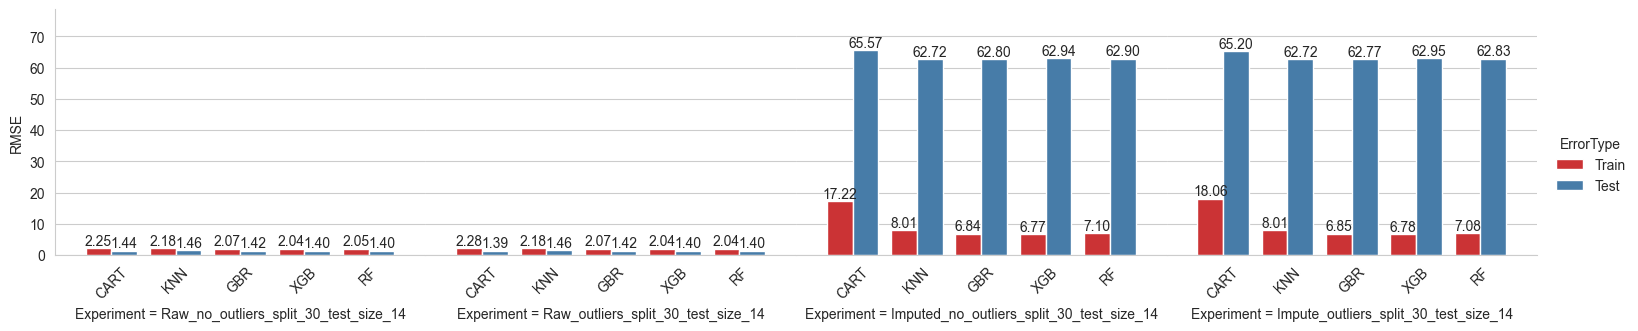

In [58]:
def results_to_dataframe(experiment_results):
    data = []
    for experiment, models in experiment_results.items():
        for model_name, model_info in models.items():
            train_rmse = model_info["train_rmse"]
            test_rmse = model_info["test_rmse"]
            data.append({"Experiment": experiment, "Model": model_name, "ErrorType": "Train", "RMSE": train_rmse})
            data.append({"Experiment": experiment, "Model": model_name, "ErrorType": "Test", "RMSE": test_rmse})

    return pd.DataFrame(data)

def plot_all_experiment_results_comparison(df):
    sns.set_style('whitegrid')
    g = sns.catplot(x="Model", y="RMSE", hue="ErrorType", col="Experiment",
                    data=df, kind="bar", height=4, aspect=1, palette='Set1')

    for ax in g.axes.flat[1:]:
        sns.despine(ax=ax, left=True)
    for ax in g.axes.flat:
        ax.set_xlabel(ax.get_title())
        ax.set_title('')
        ax.margins(x=0.1)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

        # Add RMSE labels on top of each bar with two decimal places
        for c in ax.containers:
            ax.bar_label(c, label_type='edge', labels=[f"{v.get_height():.2f}" for v in c])
        ax.margins(y=0.2)

    plt.subplots_adjust(wspace=0, bottom=0.3, left=0.06)
    plt.show()

# Example usage:
experiment_results = hypothesis_results4
df = results_to_dataframe(experiment_results)
plot_all_experiment_results_comparison(df)


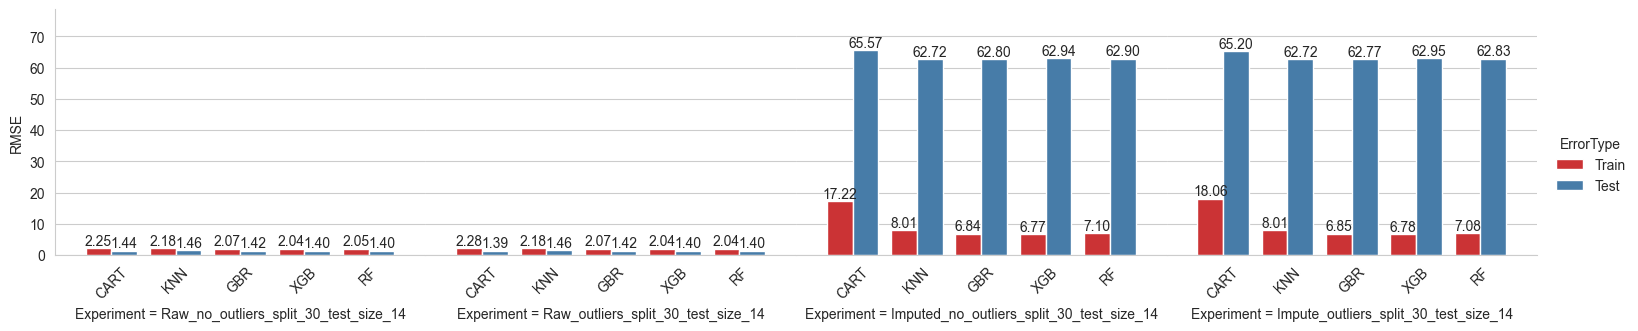

ValueError: The number of FixedLocator locations (20), usually from a call to set_ticks, does not match the number of labels (80).

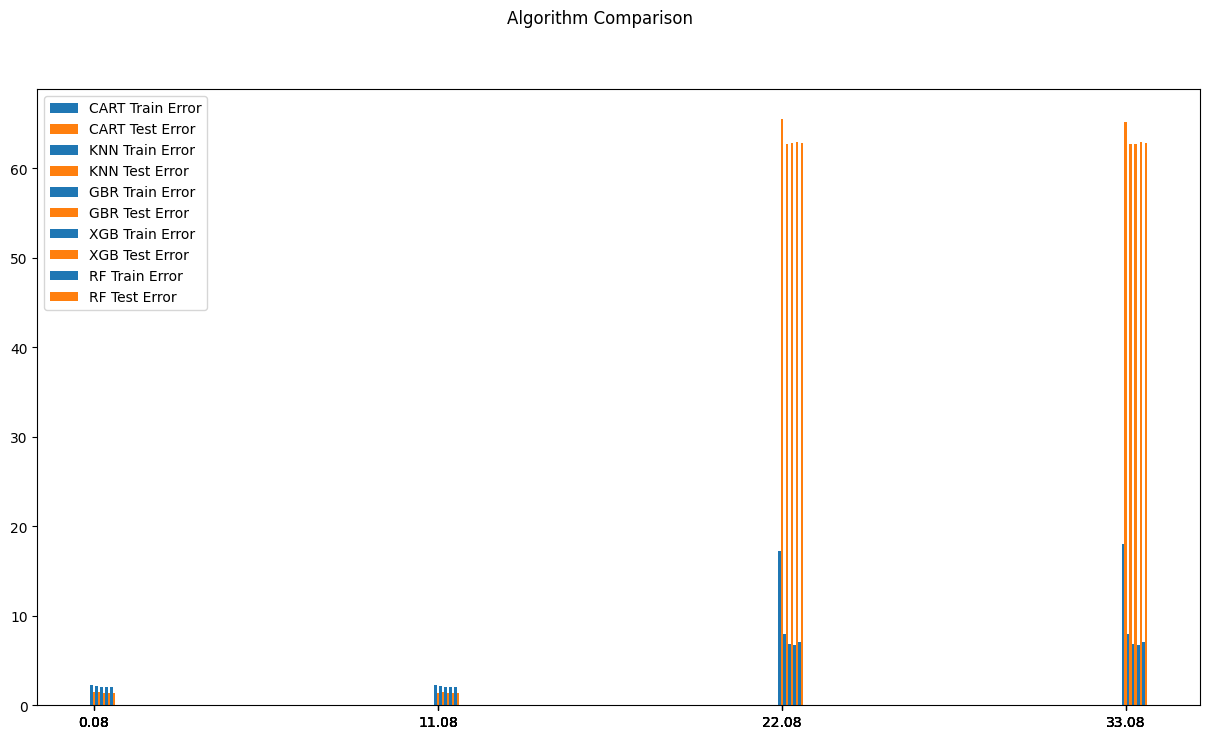

In [45]:
plot_rmse_experiment_comparison(hypothesis_results4)


In [ ]:
df = load_raw_data("Test_data.csv")
raw_hourly = df.resample('D').mean()
raw_ts_1_daily = raw_hourly['ts1'].dropna()
raw_ts_2_daily = raw_hourly['ts2'].dropna()
# Run the Monte Carlo simulation on your time series data
print('Univariate')
average_results = monte_carlo_simulation(raw_ts_1_daily, n_trials=1000)
print(average_results)
average_results = monte_carlo_simulation(raw_ts_2_daily, n_trials=1000)
print(average_results)
print('Multivariate')
# Run the Monte Carlo simulation on your time series data
average_results = monte_carlo_simulation_mult(raw_ts_1_daily, raw_ts_2_daily)
print(average_results)

Experiment 1 Raw NO

In [ ]:
hypothesis_results = {}

In [ ]:
# 1. Split train/test
# train_data, test_data = train_test_split(raw_rt_daily, test_size=0.2, shuffle=False)
train_data, test_data = raw_rt_daily.iloc[:int(len(raw_rt_daily)*0.8), :], raw_rt_daily.iloc[int(len(raw_rt_daily)*0.8):, :]
#set up data for supervised learning for H1: ts1 pred ts1
train_transformed = prepare_time_series_data(train_data, 'ts1', lags)
test_transformed = prepare_time_series_data(test_data, 'ts1', lags)
train_transformed = train_transformed.drop(['ts2'], axis=1)
test_transformed = test_transformed.drop(['ts2'], axis=1)
# 2. Scale based on train set
train_data_scaled, test_data_scaled, scaler_X, scaler_Y = scale_data(train_transformed, test_transformed, 'ts1')
# 3. Create supervised learning data by adding datetime features and lagged features
train_data_df = pd.DataFrame(train_data_scaled, index=train_transformed.index, columns=train_transformed.columns)
test_data_df = pd.DataFrame(test_data_scaled, index=test_transformed.index, columns=test_transformed.columns)
X_train, Y_train = extract_column(train_data_df, 'ts1')
X_test, Y_test = extract_column(test_data_df, 'ts1')


hypothesis = 'H1'
experiment = 'Raw_no_outliers'+"_split_"+str(n_splits)+"_test_size_"+str(test_size)

results = run_experiment(models_and_param_grids, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results[experiment+hypothesis] = results


In [ ]:
# 1. Split train/test
train_data, test_data = raw_rt_daily.iloc[:int(len(raw_rt_daily)*0.8), :], raw_rt_daily.iloc[int(len(raw_rt_daily)*0.8):, :]
#set up data for supervised learning for H1: ts1 pred ts1
train_transformed = prepare_time_series_data(train_data, 'ts2', lags)
test_transformed = prepare_time_series_data(test_data, 'ts2', lags)
train_transformed = train_transformed.drop(['ts1'], axis=1)
test_transformed = test_transformed.drop(['ts1'], axis=1)
# 2. Scale based on train set
train_data_scaled, test_data_scaled, scaler_X, scaler_Y = scale_data(train_transformed, test_transformed, 'ts2')
# 3. Create supervised learning data by adding datetime features and lagged features
train_data_df = pd.DataFrame(train_data_scaled, index=train_transformed.index, columns=train_transformed.columns)
test_data_df = pd.DataFrame(test_data_scaled, index=test_transformed.index, columns=test_transformed.columns)
X_train, Y_train = extract_column(train_data_df, 'ts2')
X_test, Y_test = extract_column(test_data_df, 'ts2')

hypothesis = 'H2'+"_split_"+str(n_splits)+"_test_size_"+str(test_size)
experiment = 'Raw_no_outliers'

results = {}

results = run_experiment(models_and_param_grids, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results[experiment+hypothesis] = results

In [ ]:
# 1. Split train/test
train_data, test_data = raw_rt_daily.iloc[:int(len(raw_rt_daily)*0.8), :], raw_rt_daily.iloc[int(len(raw_rt_daily)*0.8):, :]
#set up data for supervised learning for H1: ts1 pred ts1
train_transformed = prepare_time_series_data(train_data, 'ts1', lags)
test_transformed = prepare_time_series_data(test_data, 'ts1', lags)
train_transformed = train_transformed.drop(['ts1'], axis=1)
test_transformed = test_transformed.drop(['ts1'], axis=1)
# 2. Scale based on train set
train_data_scaled, test_data_scaled, scaler_X, scaler_Y = scale_data(train_transformed, test_transformed, 'ts2')
# 3. Create supervised learning data by adding datetime features and lagged features
train_data_df = pd.DataFrame(train_data_scaled, index=train_transformed.index, columns=train_transformed.columns)
test_data_df = pd.DataFrame(test_data_scaled, index=test_transformed.index, columns=test_transformed.columns)
X_train, Y_train = extract_column(train_data_df, 'ts2')
X_test, Y_test = extract_column(test_data_df, 'ts2')


hypothesis = 'H3'+"_split_"+str(n_splits)+"_test_size_"+str(test_size)
experiment = 'Raw_no_outliers'

results = {}

results = run_experiment(models_and_param_grids, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results[experiment+hypothesis] = results

In [ ]:
# 1. Split train/test
train_data, test_data = raw_rt_daily.iloc[:int(len(raw_rt_daily)*0.8), :], raw_rt_daily.iloc[int(len(raw_rt_daily)*0.8):, :]
#set up data for supervised learning for H1: ts1 pred ts1
train_transformed = prepare_time_series_data(train_data, 'ts2', lags)
test_transformed = prepare_time_series_data(test_data, 'ts2', lags)
train_transformed = train_transformed.drop(['ts2'], axis=1)
test_transformed = test_transformed.drop(['ts2'], axis=1)
# 2. Scale based on train set
train_data_scaled, test_data_scaled, scaler_X, scaler_Y = scale_data(train_transformed, test_transformed, 'ts1')
# 3. Create supervised learning data by adding datetime features and lagged features
train_data_df = pd.DataFrame(train_data_scaled, index=train_transformed.index, columns=train_transformed.columns)
test_data_df = pd.DataFrame(test_data_scaled, index=test_transformed.index, columns=test_transformed.columns)
X_train, Y_train = extract_column(train_data_df, 'ts1')
X_test, Y_test = extract_column(test_data_df, 'ts1')


hypothesis = 'H4'+"_split_"+str(n_splits)+"_test_size_"+str(test_size)
experiment = 'Raw_no_outliers'

results = {}

results = run_experiment(models_and_param_grids, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results[experiment+hypothesis] = results

Experiment 2 Raw WO

In [ ]:
rt_1 = train_data['ts1']
squared_rt2 = rt_1.pow(2).dropna()

# Perform cluster-based outlier detection for both series
outliers_rt1 = cluster_based_outlier_detection(squared_rt2)
outliers_rt1[outliers_rt1['outliers'] == 1]

# Plot the original series rt_1
plt.figure(figsize=(12, 6))
plt.plot(rt_1, label='rt_1')

# Get the indices and values of the outliers
outlier_indices = outliers_rt1[outliers_rt1['outliers'] == 1].index
outlier_values = rt_1.loc[outlier_indices]

# Plot the outliers as red dots
plt.scatter(outlier_indices, outlier_values, color='red', label='Outliers')

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('Return Series with Outliers')
plt.legend()

# Show the plot
plt.show()

In [ ]:

# 1. Split train/test
# train_data, test_data = train_test_split(raw_rt_daily, test_size=0.2, shuffle=False)
train_data, test_data = raw_rt_daily.iloc[:int(len(raw_rt_daily)*0.8), :], raw_rt_daily.iloc[int(len(raw_rt_daily)*0.8):, :]
#set up data for supervised learning for H1: ts1 pred ts1
train_transformed = prepare_time_series_data(train_data, 'ts1', lags, detect_outliers=True)
test_transformed = prepare_time_series_data(test_data, 'ts1', lags, detect_outliers=True)
# train_transformed = prepare_time_series_data(train_data, 'ts1_raw', lags)
# test_transformed = prepare_time_series_data(test_data, 'ts1_raw', lags)
train_transformed = train_transformed.drop(['ts2'], axis=1)
test_transformed = test_transformed.drop(['ts2'], axis=1)
# 2. Scale based on train set
train_data_scaled, test_data_scaled, scaler_X, scaler_Y = scale_data(train_transformed, test_transformed, 'ts1')
# 3. Create supervised learning data by adding datetime features and lagged features
train_data_df = pd.DataFrame(train_data_scaled, index=train_transformed.index, columns=train_transformed.columns)
test_data_df = pd.DataFrame(test_data_scaled, index=test_transformed.index, columns=test_transformed.columns)
X_train, Y_train = extract_column(train_data_df, 'ts1')
X_test, Y_test = extract_column(test_data_df, 'ts1')

hypothesis = 'H1'+"_split_"+str(n_splits)+"_test_size_"+str(test_size)
experiment = 'Raw_outliers'

results = run_experiment(models_and_param_grids, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results[experiment+hypothesis] = results



In [ ]:
# 1. Split train/test
train_data, test_data = raw_rt_daily.iloc[:int(len(raw_rt_daily)*0.8), :], raw_rt_daily.iloc[int(len(raw_rt_daily)*0.8):, :]
#set up data for supervised learning for H1: ts1 pred ts1
train_transformed = prepare_time_series_data(train_data, 'ts2', lags, detect_outliers=True)
test_transformed = prepare_time_series_data(test_data, 'ts2', lags, detect_outliers=True)
train_transformed = train_transformed.drop(['ts1'], axis=1)
test_transformed = test_transformed.drop(['ts1'], axis=1)
# 2. Scale based on train set
train_data_scaled, test_data_scaled, scaler_X, scaler_Y = scale_data(train_transformed, test_transformed, 'ts2')
# 3. Create supervised learning data by adding datetime features and lagged features
train_data_df = pd.DataFrame(train_data_scaled, index=train_transformed.index, columns=train_transformed.columns)
test_data_df = pd.DataFrame(test_data_scaled, index=test_transformed.index, columns=test_transformed.columns)
X_train, Y_train = extract_column(train_data_df, 'ts2')
X_test, Y_test = extract_column(test_data_df, 'ts2')

hypothesis = 'H2'+"_split_"+str(n_splits)+"_test_size_"+str(test_size)
experiment = 'Raw_outliers'

results = {}

results = run_experiment(models_and_param_grids, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results[experiment+hypothesis] = results

In [ ]:
# 1. Split train/test
train_data, test_data = raw_rt_daily.iloc[:int(len(raw_rt_daily)*0.8), :], raw_rt_daily.iloc[int(len(raw_rt_daily)*0.8):, :]
#set up data for supervised learning for H1: ts1 pred ts1
train_transformed = prepare_time_series_data(train_data, 'ts1', lags, detect_outliers=True)
test_transformed = prepare_time_series_data(test_data, 'ts1', lags, detect_outliers=True)
train_transformed = train_transformed.drop(['ts1'], axis=1)
test_transformed = test_transformed.drop(['ts1'], axis=1)
# 2. Scale based on train set
train_data_scaled, test_data_scaled, scaler_X, scaler_Y = scale_data(train_transformed, test_transformed, 'ts2')
# 3. Create supervised learning data by adding datetime features and lagged features
train_data_df = pd.DataFrame(train_data_scaled, index=train_transformed.index, columns=train_transformed.columns)
test_data_df = pd.DataFrame(test_data_scaled, index=test_transformed.index, columns=test_transformed.columns)
X_train, Y_train = extract_column(train_data_df, 'ts2')
X_test, Y_test = extract_column(test_data_df, 'ts2')


hypothesis = 'H3'+"_split_"+str(n_splits)+"_test_size_"+str(test_size)
experiment = 'Raw_outliers'

results = {}

results = run_experiment(models_and_param_grids, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results[experiment+hypothesis] = results

In [ ]:
# 1. Split train/test
train_data, test_data = raw_rt_daily.iloc[:int(len(raw_rt_daily)*0.8), :], raw_rt_daily.iloc[int(len(raw_rt_daily)*0.8):, :]
#set up data for supervised learning for H1: ts1 pred ts1
train_transformed = prepare_time_series_data(train_data, 'ts2', lags, detect_outliers=True)
test_transformed = prepare_time_series_data(test_data, 'ts2', lags, detect_outliers=True)
train_transformed = train_transformed.drop(['ts2'], axis=1)
test_transformed = test_transformed.drop(['ts2'], axis=1)
# 2. Scale based on train set
train_data_scaled, test_data_scaled, scaler_X, scaler_Y = scale_data(train_transformed, test_transformed, 'ts1')
# 3. Create supervised learning data by adding datetime features and lagged features
train_data_df = pd.DataFrame(train_data_scaled, index=train_transformed.index, columns=train_transformed.columns)
test_data_df = pd.DataFrame(test_data_scaled, index=test_transformed.index, columns=test_transformed.columns)
X_train, Y_train = extract_column(train_data_df, 'ts1')
X_test, Y_test = extract_column(test_data_df, 'ts1')


hypothesis = 'H4'+"_split_"+str(n_splits)+"_test_size_"+str(test_size)
experiment = 'Raw_outliers'

results = {}

results = run_experiment(models_and_param_grids, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results[experiment+hypothesis] = results

Experiment 3 Imp NO

In [ ]:
# 1. Split train/test rt_d.iloc[:int(len(raw_rt_daily)*0.8), :]
train_data, test_data = rt_d.iloc[:int(len(raw_rt_daily)*0.8), :], raw_rt_daily.iloc[int(len(raw_rt_daily)*0.8):, :]
#set up data for supervised learning for H1: ts1 pred ts1
train_transformed = prepare_time_series_data(train_data, 'ts1', lags)
test_transformed = prepare_time_series_data(test_data, 'ts1', lags)
train_transformed = train_transformed.drop(['ts2'], axis=1)
test_transformed = test_transformed.drop(['ts2'], axis=1)
# 2. Scale based on train set
train_data_scaled, test_data_scaled, scaler_X, scaler_Y = scale_data(train_transformed, test_transformed, 'ts1')
# 3. Create supervised learning data by adding datetime features and lagged features
train_data_df = pd.DataFrame(train_data_scaled, index=train_transformed.index, columns=train_transformed.columns)
test_data_df = pd.DataFrame(test_data_scaled, index=test_transformed.index, columns=test_transformed.columns)
X_train, Y_train = extract_column(train_data_df, 'ts1')
X_test, Y_test = extract_column(test_data_df, 'ts1')


hypothesis = 'H1'+"_split_"+str(n_splits)+"_test_size_"+str(test_size)
experiment = 'Imputed_no_outliers'

results = run_experiment(models_and_param_grids, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results[experiment+hypothesis] = results


In [ ]:
# 1. Split train/test
train_data, test_data = rt_d.iloc[:int(len(raw_rt_daily)*0.8), :], raw_rt_daily.iloc[int(len(raw_rt_daily)*0.8):, :]
#set up data for supervised learning for H1: ts1 pred ts1
train_transformed = prepare_time_series_data(train_data, 'ts2', lags)
test_transformed = prepare_time_series_data(test_data, 'ts2', lags)
train_transformed = train_transformed.drop(['ts1'], axis=1)
test_transformed = test_transformed.drop(['ts1'], axis=1)
# 2. Scale based on train set
train_data_scaled, test_data_scaled, scaler_X, scaler_Y = scale_data(train_transformed, test_transformed, 'ts2')
# 3. Create supervised learning data by adding datetime features and lagged features
train_data_df = pd.DataFrame(train_data_scaled, index=train_transformed.index, columns=train_transformed.columns)
test_data_df = pd.DataFrame(test_data_scaled, index=test_transformed.index, columns=test_transformed.columns)
X_train, Y_train = extract_column(train_data_df, 'ts2')
X_test, Y_test = extract_column(test_data_df, 'ts2')

hypothesis = 'H2'+"_split_"+str(n_splits)+"_test_size_"+str(test_size)
experiment = 'Imputed_no_outliers'

results = {}

results = run_experiment(models_and_param_grids, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results[experiment+hypothesis] = results

In [ ]:
# 1. Split train/test
train_data, test_data = rt_d.iloc[:int(len(raw_rt_daily)*0.8), :], raw_rt_daily.iloc[int(len(raw_rt_daily)*0.8):, :]
#set up data for supervised learning for H1: ts1 pred ts1
train_transformed = prepare_time_series_data(train_data, 'ts1', lags)
test_transformed = prepare_time_series_data(test_data, 'ts1', lags)
train_transformed = train_transformed.drop(['ts1'], axis=1)
test_transformed = test_transformed.drop(['ts1'], axis=1)
# 2. Scale based on train set
train_data_scaled, test_data_scaled, scaler_X, scaler_Y = scale_data(train_transformed, test_transformed, 'ts2')
# 3. Create supervised learning data by adding datetime features and lagged features
train_data_df = pd.DataFrame(train_data_scaled, index=train_transformed.index, columns=train_transformed.columns)
test_data_df = pd.DataFrame(test_data_scaled, index=test_transformed.index, columns=test_transformed.columns)
X_train, Y_train = extract_column(train_data_df, 'ts2')
X_test, Y_test = extract_column(test_data_df, 'ts2')


hypothesis = 'H3'+"_split_"+str(n_splits)+"_test_size_"+str(test_size)
experiment = 'Imputed_no_outliers'

results = {}

results = run_experiment(models_and_param_grids, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results[experiment+hypothesis] = results

In [ ]:
# 1. Split train/test
train_data, test_data = rt_d.iloc[:int(len(raw_rt_daily)*0.8), :], raw_rt_daily.iloc[int(len(raw_rt_daily)*0.8):, :]
#set up data for supervised learning for H1: ts1 pred ts1
train_transformed = prepare_time_series_data(train_data, 'ts2', lags)
test_transformed = prepare_time_series_data(test_data, 'ts2', lags)
train_transformed = train_transformed.drop(['ts2'], axis=1)
test_transformed = test_transformed.drop(['ts2'], axis=1)
# 2. Scale based on train set
train_data_scaled, test_data_scaled, scaler_X, scaler_Y = scale_data(train_transformed, test_transformed, 'ts1')
# 3. Create supervised learning data by adding datetime features and lagged features
train_data_df = pd.DataFrame(train_data_scaled, index=train_transformed.index, columns=train_transformed.columns)
test_data_df = pd.DataFrame(test_data_scaled, index=test_transformed.index, columns=test_transformed.columns)
X_train, Y_train = extract_column(train_data_df, 'ts1')
X_test, Y_test = extract_column(test_data_df, 'ts1')


hypothesis = 'H4'+"_split_"+str(n_splits)+"_test_size_"+str(test_size)
experiment = 'Imputed_no_outliers'

results = {}

results = run_experiment(models_and_param_grids, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results[experiment+hypothesis] = results


Experiment 4 Imputed WO

In [ ]:
# 1. Split train/test rt_d.iloc[:int(len(raw_rt_daily)*0.8), :]
train_data, test_data = rt_d.iloc[:int(len(raw_rt_daily)*0.8), :], raw_rt_daily.iloc[int(len(raw_rt_daily)*0.8):, :]
#set up data for supervised learning for H1: ts1 pred ts1
train_transformed = prepare_time_series_data(train_data, 'ts1', lags, detect_outliers=True)
test_transformed = prepare_time_series_data(test_data, 'ts1', lags, detect_outliers=True)
train_transformed = train_transformed.drop(['ts2'], axis=1)
test_transformed = test_transformed.drop(['ts2'], axis=1)
# 2. Scale based on train set
train_data_scaled, test_data_scaled, scaler_X, scaler_Y = scale_data(train_transformed, test_transformed, 'ts1')
# 3. Create supervised learning data by adding datetime features and lagged features
train_data_df = pd.DataFrame(train_data_scaled, index=train_transformed.index, columns=train_transformed.columns)
test_data_df = pd.DataFrame(test_data_scaled, index=test_transformed.index, columns=test_transformed.columns)
X_train, Y_train = extract_column(train_data_df, 'ts1')
X_test, Y_test = extract_column(test_data_df, 'ts1')


hypothesis = 'H1'+"_split_"+str(n_splits)+"_test_size_"+str(test_size)
experiment = 'Impute_outliers'

results = run_experiment(models_and_param_grids, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results[experiment+hypothesis] = results

In [ ]:
# 1. Split train/test rt_d.iloc[:int(len(raw_rt_daily)*0.8), :]
train_data, test_data = rt_d.iloc[:int(len(raw_rt_daily)*0.8), :], raw_rt_daily.iloc[int(len(raw_rt_daily)*0.8):, :]
#set up data for supervised learning for H1: ts1 pred ts1
train_transformed = prepare_time_series_data(train_data, 'ts2', lags, detect_outliers=True)
test_transformed = prepare_time_series_data(test_data, 'ts2', lags, detect_outliers=True)
train_transformed = train_transformed.drop(['ts1'], axis=1)
test_transformed = test_transformed.drop(['ts1'], axis=1)
# 2. Scale based on train set
train_data_scaled, test_data_scaled, scaler_X, scaler_Y = scale_data(train_transformed, test_transformed, 'ts2')
# 3. Create supervised learning data by adding datetime features and lagged features
train_data_df = pd.DataFrame(train_data_scaled, index=train_transformed.index, columns=train_transformed.columns)
test_data_df = pd.DataFrame(test_data_scaled, index=test_transformed.index, columns=test_transformed.columns)
X_train, Y_train = extract_column(train_data_df, 'ts2')
X_test, Y_test = extract_column(test_data_df, 'ts2')

hypothesis = 'H2'+"_split_"+str(n_splits)+"_test_size_"+str(test_size)
experiment = 'Impute_outliers'

results = {}

results = run_experiment(models_and_param_grids, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results[experiment+hypothesis] = results

In [ ]:
# 1. Split train/test rt_d.iloc[:int(len(raw_rt_daily)*0.8), :]
train_data, test_data = rt_d.iloc[:int(len(raw_rt_daily)*0.8), :], raw_rt_daily.iloc[int(len(raw_rt_daily)*0.8):, :]
#set up data for supervised learning for H1: ts1 pred ts1
train_transformed = prepare_time_series_data(train_data, 'ts1', lags, detect_outliers=True)
test_transformed = prepare_time_series_data(test_data, 'ts1', lags, detect_outliers=True)
train_transformed = train_transformed.drop(['ts1'], axis=1)
test_transformed = test_transformed.drop(['ts1'], axis=1)
# 2. Scale based on train set
train_data_scaled, test_data_scaled, scaler_X, scaler_Y = scale_data(train_transformed, test_transformed, 'ts2')
# 3. Create supervised learning data by adding datetime features and lagged features
train_data_df = pd.DataFrame(train_data_scaled, index=train_transformed.index, columns=train_transformed.columns)
test_data_df = pd.DataFrame(test_data_scaled, index=test_transformed.index, columns=test_transformed.columns)
X_train, Y_train = extract_column(train_data_df, 'ts2')
X_test, Y_test = extract_column(test_data_df, 'ts2')


hypothesis = 'H3'+"_split_"+str(n_splits)+"_test_size_"+str(test_size)
experiment = 'Impute_outliers'

results = {}

results = run_experiment(models_and_param_grids, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results[experiment+hypothesis] = results

In [ ]:
# 1. Split train/test rt_d.iloc[:int(len(raw_rt_daily)*0.8), :]
train_data, test_data = rt_d.iloc[:int(len(raw_rt_daily)*0.8), :], raw_rt_daily.iloc[int(len(raw_rt_daily)*0.8):, :]
#set up data for supervised learning for H1: ts1 pred ts1
train_transformed = prepare_time_series_data(train_data, 'ts2', lags, detect_outliers=True)
test_transformed = prepare_time_series_data(test_data, 'ts2', lags, detect_outliers=True)
train_transformed = train_transformed.drop(['ts2'], axis=1)
test_transformed = test_transformed.drop(['ts2'], axis=1)
# 2. Scale based on train set
train_data_scaled, test_data_scaled, scaler_X, scaler_Y = scale_data(train_transformed, test_transformed, 'ts1')
# 3. Create supervised learning data by adding datetime features and lagged features
train_data_df = pd.DataFrame(train_data_scaled, index=train_transformed.index, columns=train_transformed.columns)
test_data_df = pd.DataFrame(test_data_scaled, index=test_transformed.index, columns=test_transformed.columns)
X_train, Y_train = extract_column(train_data_df, 'ts1')
X_test, Y_test = extract_column(test_data_df, 'ts1')


hypothesis = 'H4'+"_split_"+str(n_splits)+"_test_size_"+str(test_size)
experiment = 'Impute_outliers'

results = {}

results = run_experiment(models_and_param_grids, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results[experiment+hypothesis] = results


## Data preparation

- Import data
- Apply imputation and cleaning methods
- Transform to returns
- Resample
- Split training and holdout

In [ ]:
# make into function
filename = "Test_data.csv"
raw_df = pd.read_csv(filename, header=None)
raw_df.columns = ['datetime', 'ts1', 'ts2']
raw_df['datetime'] = pd.to_datetime(raw_df['datetime']-719529,unit='d').round('s')
raw_df.set_index('datetime', inplace = True)

In [ ]:
def plot_time_series(ts1, ts2, ts1_label='ts1', ts2_label='ts2', figsize=(12, 10)):
    # Create subplots
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=figsize)

    # Plot first time series on first subplot
    axs[0].plot(ts1)
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Price')
    axs[0].set_title(ts1_label)

    # Plot second time series on second subplot
    axs[1].plot(ts2)
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Price')
    axs[1].set_title(ts2_label)

In [ ]:
# Function to count missing values in a series
def count_missing_values(series):
    return series.isna().sum()

# Function to find the maximum length of continuous missing values in a series
def max_missing_range(series):
    mask = series.isna()
    changes = mask.ne(mask.shift()).cumsum()
    counts = mask.groupby(changes).sum()
    counts = counts[counts > 1]
    if counts.empty:
        return 0
    else:
        return counts.max()

# Function to impute missing values in a series using a moving mean
def impute_missing_values(series, window):
    if series.isnull().any():
        rolling_mean = series.rolling(window=window, min_periods=1).mean()
        return series.fillna(rolling_mean)
    else:
        return series

# Function to convert intervals to days
def intervals_to_days(intervals):
    minutes = intervals * 2
    hours = minutes / 60
    days = hours / 24
    return days

def rolling_mean(series, window=120):
    if series.isnull().any():
        # Create a copy of the series
        imputed_series = series.copy()
        
        # Identify the non-missing blocks of data
        non_missing_blocks = series.notna().astype(int).groupby(series.isna().astype(int).cumsum()).cumsum()

        # Loop through the non-missing blocks and calculate the rolling mean for each block
        for _, block in non_missing_blocks.groupby(non_missing_blocks):
            start_idx = block.index[0]
            end_idx = block.index[-1] + pd.Timedelta(minutes=2)  # Change this line to fix the error
            rolling_mean_block = series[start_idx:end_idx].rolling(window=window, min_periods=1).mean()
            imputed_series[start_idx:end_idx] = series[start_idx:end_idx].fillna(rolling_mean_block)
        
        imputed_series.fillna(method='bfill', inplace=True)  # Backfill since missing starting data
    else:
        imputed_series = series
    return imputed_series


def impute_missing_values(data, short_gap_threshold=120, long_gap_threshold = 2880): #120 is 240 minutes, 2880 is 4 days

    # Identify the missing value gaps
    missing_gaps = data.isna().astype(int).groupby(data.notna().astype(int).cumsum()).cumsum()

    # Apply moving mean imputation for shorter gaps
    data_short_gaps = data.copy()
    data_short_gaps[missing_gaps <= short_gap_threshold] = rolling_mean(data_short_gaps)
    
    # Apply moving mean imputation for longer gaps
    data_long_gaps = data.copy()
    data_long_gaps[missing_gaps > short_gap_threshold] = rolling_mean(data_long_gaps,long_gap_threshold )

    # Combine the imputed data
    data_imputed = data_short_gaps.combine_first(data_long_gaps)
    
    # Impute any leftover missing values using backfill and forward fill methods
    data_imputed.fillna(method='bfill', inplace=True)  # Backfill
    data_imputed.fillna(method='ffill', inplace=True)  # Forward fill
    
    return data_imputed

def fill_forward_saturdays(series):
    # Make a copy of the series
    filled_series = series.copy()
    # Filter the index to include only Saturdays
    saturday_index = series.index.weekday == 5
    # Forward fill only on Saturdays
    filled_series.loc[saturday_index] = filled_series.loc[saturday_index].fillna(method='ffill')
    # Return the filled series
    return filled_series

In [ ]:
ts1 = raw_df['ts1']
ts2 = raw_df['ts2']

# Get the maximum missing range in ts1 and ts2
max_ts1 = max_missing_range(ts1)
max_ts2 = max_missing_range(ts2)
print(f"Max missing range in ts1: {max_ts1}")
print(f"Max missing range in ts2: {max_ts2}")


# Impute missing values in ts1 and ts2 using their respective maximum missing ranges
imputed_ts1 = impute_missing_values(ts1,long_gap_threshold = max_ts1)
imputed_ts2 = impute_missing_values(ts2, long_gap_threshold = max_ts2)

# Print the number of missing values in the imputed series
print(f"Missing values in imputed ts1: {imputed_ts1.isna().sum()}")
print(f"Missing values in imputed ts2: {imputed_ts2.isna().sum()}")

# Calculate the maximum missing range in the imputed series
max_imputed_ts1 = max_missing_range(imputed_ts1)
max_imputed_ts2 = max_missing_range(imputed_ts2)

# Print the maximum missing range in the imputed series
print(f"Max missing range in imputed ts1: {max_imputed_ts1}")
print(f"Max missing range in imputed ts2: {max_imputed_ts2}")
#PLot original data
# plot_time_series(ts1, ts2)

# Plot the imputed time series
# plot_time_series(imputed_ts1, imputed_ts2)

In [ ]:
clean_df =  pd.concat([imputed_ts1, imputed_ts2], axis=1)
print(clean_df.isna().sum())
ts_1_imp = clean_df['ts1']
ts_2_imp = clean_df['ts2']


rt = np.log(clean_df/clean_df.shift(1))
rt.dropna(inplace=True)
rt_1 = rt['ts1']
rt_2 = rt['ts2']
plot_time_series(rt_1, rt_2, 'rt_1', 'rt_2')
print(rt.isna().sum())

In [ ]:
clean_df.to_csv('clean_df.csv')

In [ ]:
# rt.to_csv('rt_c.csv', index=True)
print((rt == 0).sum())
rt.describe()


Data preparation

In [ ]:
# def create_holdout_validation_set(data, days=30):
#     validation_start_date = data.index.max() - pd.DateOffset(days=days - 1)
#     train_data = data[data.index < validation_start_date]
#     validation_data = data[data.index >= validation_start_date]

#     return train_data, validation_data

def split_time_series(data, percent_train):
    n_train = int(len(data) * percent_train)
    train_data = data.iloc[:n_train]
    test_data = data.iloc[n_train:]

    return train_data, test_data

In [ ]:
# resample to daily frequency for forecasting
# create holdout set of last month for OOS validation

clean_df_daily = clean_df.resample('D').mean()
ts_1_D = clean_df_daily['ts1']
ts_2_D = clean_df_daily['ts2']
# #create holdout set of last month for OOS validation
ts_1_D_train, ts_1_D_validation = split_time_series(ts_1_D, 0.8)
ts_2_D_train, ts_2_D_validation = split_time_series(ts_2_D, 0.8)

rt_daily = rt.resample('D').mean()
rt_1_D = rt_daily['ts1']
rt_2_D = rt_daily['ts2']
#create holdout set of last month for OOS validation
rt_1_D_train, rt_1_D_validation = split_time_series(rt_1_D, 0.8)
rt_2_D_train, rt_2_D_validation = split_time_series(rt_2_D, 0.8)




In [ ]:
# rt_daily.to_csv('rt_daily.csv', index=True)
(rt_daily==0).sum()

a. Feature engineering 


In [ ]:
# Define a function for rolling forecast origin split
def rolling_forecast_origin_split(data, window_size):
    # Iterate through the data using a rolling window
    for i in range(window_size, len(data)):
        # Split the data into training and testing sets
        train_data = data[:i-window_size]
        test_data = data[i-window_size:i]
        # Yield the training and testing sets
        yield train_data, test_data
        

def create_lagged_features(series, lag=1):
    # Create a DataFrame from the input series
    df = pd.DataFrame(series)
    
    # Create lagged features
    for i in range(1, lag + 1):
        df[f"lag_{i}"] = df.shift(i)
    
    # Drop rows with missing values caused by shifting
    df.dropna(inplace=True)
    
    return df

def generate_lagged_features(ts_data, var, max_lag):
    for t in range(1, max_lag+1):
        ts_data[var+'_lag'+str(t)] = ts_data[var].shift(t, freq='1D')
    ts_data.dropna(inplace=True)


Benchmark

Univariate
- b. Training
- c. Testing

In [ ]:
# make return the model as well
def fit_arima(train_data, test_data):
    # Use auto_arima to select the best ARIMA model
    model = sm.tsa.arima.auto_arima(train_data, seasonal=False, suppress_warnings=True)
    arima_preds = model.predict(start=len(train_data), end=len(train_data)+len(test_data)-1)
    # Return the fitted model
    return model, arima_preds


# Function to fit an ARIMA model
def fit_arima(train_data, test_data):
    # Fit an ARIMA model to the training data
    arima_model = ARIMA(train_data, order=(1, 0, 1)).fit(disp=0)
    # Generate predictions for the test data using the fitted model
    arima_preds = arima_model.predict(start=len(train_data), end=len(train_data)+len(test_data)-1)
    return arima_preds, arima_model

# Function to fit a GARCH model
def fit_garch(train_data, test_data):
    # Fit a GARCH model to the training data
    garch_model = arch_model(train_data, vol='Garch', p=1, o=0, q=1).fit(disp='off')
    # Generate predictions for the test data using the fitted model
    garch_preds = garch_model.forecast(horizon=len(test_data)).mean.iloc[-1].values
    return garch_preds, garch_model

# Function to fit a VAR model
def fit_var(train_data, test_data):
    # Fit a VAR model to the training data
    model = VAR(train_data)
    fit_model = model.fit()
    lag_order = results.k_ar
    # Generate predictions for the test data using the fitted model
    preds = fit_model.forecast(train_data.values[-lag_order:], len(test_data))
    return preds, fit_model


def tune_sarima(y_train, seasonal=True):
    model = pm.auto_arima(y_train,
                          seasonal=seasonal,
                          stepwise=True,
                          suppress_warnings=True,
                          trace=True)
    return model


def analyze_model(model):
    # Generate diagnostic plots for the model
    fig, ax = plt.subplots(figsize=(12, 8))
    plot_acf(model.resid, ax=ax, lags=30)
    plt.show()

    fig, ax = plt.subplots(figsize=(12, 8))
    plot_pacf(model.resid, ax=ax, lags=30)
    plt.show()

    fig, ax = plt.subplots(figsize=(12, 8))
    model.plot_diagnostics(ax=ax)
    plt.show()

    # Print a summary of the model
    print(model.summary())

Multivariate
- b. Training
- c. Testing

In [ ]:
def train_random_forest(train_x, train_y, test_x, test_y):
    model = RandomForestRegressor()
    model.fit(train_x, train_y)
    preds = model.predict(test_x)
    mse, mae, mape = evaluate_predictions(test_y, preds)

    print("Random Forest")
    print(f"MSE: {mse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"MAPE: {mape:.3f}")
    
    return mse, mae, mape

def train_lightgbm(train_x, train_y, test_x, test_y):
    # Fit LightGBM model
    params = {'objective': 'regression'}
    d_train = lgb.Dataset(train_x, label=train_y)
    model = lgb.train(params, d_train)
    preds = model.predict(test_x)

    # Evaluate predictions
    mse, mae, mape = evaluate_predictions(test_y, preds)

    print("LightGBM")
    print(f"MSE: {mse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"MAPE: {mape:.3f}")
    
    return mse, mae, mape



def create_dataset(dataset, look_back=1):
    data_x, data_y = [], []
    for i in range(len(dataset) - look_back):
        data_x.append(dataset[i:(i + look_back), 0])
        data_y.append(dataset[i + look_back, 0])
    return np.array(data_x), np.array(data_y)

def unscale_data(pred, actual):
    scaler = MinMaxScaler()
    scaler.fit(actual)
    pred = scaler.inverse_transform(pred)
    actual = scaler.inverse_trans
    form(actual)
    return pred, actual


def scale_data(train_data, test_data):
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)
    return train_scaled, test_scaled


def fit_lstm(train_x, train_y, test_x, test_y, lstm_units=50, look_back=1, num_epochs=10, batch_size=32):
    # Reshape input to be [samples, time steps, features]
    train_x = train_x.reshape((train_x.shape[0], look_back, 1))
    test_x = test_x.reshape((test_x.shape[0], look_back, 1))

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(8, input_shape=(look_back, 1), return_sequences=True))
    model.add(LSTM(4))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mape'])

    # Fit the model
    model.fit(train_x, train_y, epochs=num_epochs, batch_size=batch_size, verbose=2)

    # Make predictions
    train_pred = model.predict(train_x)
    test_pred = model.predict(test_x)

    # Inverse scaling of the predictions
    train_pred = scaler.inverse_transform(train_pred)
    train_y = scaler.inverse_transform(train_y)
    test_pred = scaler.inverse_transform(test_pred)
    test_y = scaler.inverse_transform(test_y)

    # Create a DataFrame of the predictions and actual values
    train_results = pd.DataFrame({'Actual': train_y.flatten(), 'Predicted': train_pred.flatten()}, index=train_data.index[1:])
    test_results = pd.DataFrame({'Actual': test_y.flatten(), 'Predicted': test_pred.flatten()}, index=test_data.index[1:])

    # Evaluate the predictions
    train_mse, train_mae, train_mape = evaluate_predictions(train_y, train_pred)
    test_mse, test_mae, test_mape = evaluate_predictions(test_y, test_pred)
    
    # Evaluate the model on the test set
    loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test loss: {loss}")

    # Print the evaluation metrics
    print("Train MSE: {:.3f}, Train MAE: {:.3f}, Train MAPE: {:.3f}".format(train_mse, train_mae, train_mape))
    print("Test MSE: {:.3f}, Test MAE: {:.3f}, Test MAPE: {:.3f}".format(test_mse, test_mae, test_mape))

    return pd.concat([train_results, test_results])



def build_lstm_model(units=50, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

def tune_lstm(X_train, y_train):
    param_grid = {
        'units': [50, 100],
        'activation': ['relu', 'tanh'],
        'optimizer': [Adam(learning_rate=0.001), Adam(learning_rate=0.01)]
    }
    model = KerasRegressor(build_fn=build_lstm_model, epochs=50, batch_size=32, verbose=0)
    tscv = TimeSeriesSplit(n_splits=5)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')
    grid_result = grid.fit(X_train, y_train)
    best_params = grid_result.best_params_
    best_lstm_model = build_lstm_model(**best_params)
    best_lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    
    print(f"Best LSTM model with parameters {best_params}")
    return best_lstm_model


OPtimisation

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()
#####

from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

###


tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)


#####
from sklearn.model_selection import GridSearchCV

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)

grid_search_cv.fit(X_train, y_train)

grid_search_cv.best_estimator_

from sklearn.metrics import accuracy_score

y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

grid_search.best_params_
grid_search.best_estimator_
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)


d. Evaluation


In [ ]:
# def evaluate(y_true, y_pred):
#     mae = mean_absolute_error(y_true, y_pred)
#     mse = mean_squared_error(y_true, y_pred)
#     rmse = np.sqrt(mse)
#     mape = mean_absolute_percentage_error(y_true, y_pred)
#     r2 = r2_score(y_true, y_pred)
#     # msle = mean_squared_log_error(y_true, y_pred)

#     return {
#         'mae': mae,
#         'mse': mse,
#         'rmse': rmse,
#         'mape': mape,
#         'r2': r2,
#     }
    
def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    # msle = mean_squared_log_error(y_true, y_pred)
    return {
        'rmse': rmse,
    }
    

    

e. Cross validation


In [ ]:
def rolling_window_kfold_validation(model, X_train, y_train, window_size=30, n_splits=5):

    cv_scores = defaultdict(list)
    kf = KFold(n_splits=n_splits, shuffle=False)
    for train_index, test_index in kf.split(X_train):
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        y_pred_fold = []
        
        for X_train_window, y_train_window, X_test_window, y_test_window in rolling_forecast_origin_split(X_train_fold, y_train_fold, window_size):
            model.fit(X_train_window, y_train_window)
            y_pred_window = model.predict(X_test_window)
            y_pred_fold.extend(y_pred_window)

        evaluation_result = evaluate(y_test_fold, y_pred_fold)

        for metric, value in evaluation_result.items():
            cv_scores[metric].append(value)

    # Calculate the mean and standard deviation of the cross-validation scores
    mean_std_cv_scores = {}
    for metric, scores in cv_scores.items():
        mean_std_cv_scores[metric] = {'mean': np.mean(scores), 'std': np.std(scores)}

    return mean_std_cv_scores






Select best model: H1 H2 H3 H4 BIC 

Optimization of best model

f. Residual and diagnostic

In [ ]:
#   def residual_analysis(model, data1, data2):
#         # perform residual analysis and return the plot and print statements
#     residuals = model.resid
#     fig, ax = plt.subplots(figsize=(12, 6))
#     ax.plot(residuals)
#     ax.axhline(y=0, color='r', linestyle='-')
#     ax.set_xlabel('Time')
#     ax.set_ylabel('Residuals')
#     ax.set_title('Residual Analysis')
#     plt.show()
#     print('Residual Analysis:')
#     print('Mean of residuals:', round(residuals.mean(), 4))
#     print('Standard deviation of residuals:', round(residuals.std(), 4))

def diagnostics(model, data1, data2):
    # perform diagnostics and return the print statements
    print('Diagnostics:')
    print(model.summary())


#write this so that it takes the predicted values and the actual values
  
def residual_analysis(y_pred, y_train):

    # Calculate the residuals
    residuals = y_train - y_pred

    # Plot the residuals
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(residuals)
    ax.axhline(y=0, color='r', linestyle='-')
    ax.set_xlabel('Time')
    ax.set_ylabel('Residuals')
    ax.set_title('Residual Analysis')
    plt.show()
    print('Residual Analysis:')
    print('Mean of residuals:', round(residuals.mean(), 4))
    print('Standard deviation of residuals:', round(residuals.std(), 4))

    # Check for autocorrelation
    print("Autocorrelation plot:")
    plot_acf(residuals)
    plt.show()

    # Check for normality
    print("Normality Q-Q plot:")
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.show()

    # Check for homoscedasticity
    print("Homoscedasticity scatter plot:")
    plt.scatter(y_pred, residuals)
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.axhline(y=0, color="r", linestyle="--")
    plt.show()

    # Perform Ljung-Box test for autocorrelation in residuals
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)  
    print("Ljung-Box test for autocorrelation in residuals:")
    print(lb_test)
    # Assess the p-value of the Ljung-Box test
    p_value = lb_test['lb_pvalue'][10]
    if p_value < 0.05:
        print("The Ljung-Box test suggests that there is autocorrelation in the residuals (p-value < 0.05).")
    else:
        print("The Ljung-Box test suggests that there is no significant autocorrelation in the residuals (p-value >= 0.05).")
        
    # Perform Breusch-Godfrey test for autocorrelation in residuals
    bg_test = acorr_breusch_godfrey(model, X_train, nlags=10)
    print("\nBreusch-Godfrey test for autocorrelation in residuals:")
    if bg_test[1] < 0.05:
        print(f"LM test statistic: {bg_test[0]}, p-value: {bg_test[1]}")
        print("The Breusch-Godfrey test suggests that there is autocorrelation in the residuals (p-value < 0.05).")
    else:
        print(f"LM test statistic: {bg_test[0]}, p-value: {bg_test[1]}")
        print("The Breusch-Godfrey test suggests that there is no significant autocorrelation in the residuals (p-value >= 0.05).")

    # Perform Jarque-Bera test for normality in residuals
    jb_test = jarque_bera(residuals)
    print("\nJarque-Bera test for normality in residuals:")
    if jb_test[1] < 0.05:
        print(f"Test statistic: {jb_test[0]}, p-value: {jb_test[1]}")
        print("The Jarque-Bera test suggests that the residuals are not normally distributed (p-value < 0.05).")
    else:
        print(f"Test statistic: {jb_test[0]}, p-value: {jb_test[1]}")
        print("The Jarque-Bera test suggests that the residuals are normally distributed (p-value >= 0.05).")

    # Perform White test for heteroscedasticity in residuals
    white_test = het_white(residuals, X_train)
    print("\nWhite test for heteroscedasticity in residuals:")
    if white_test[1] < 0.05:
        print(f"Test statistic: {white_test[0]}, p-value: {white_test[1]}")
        print("The White test suggests that there is heteroscedasticity in the residuals (p-value < 0.05).")
    else:
        print(f"Test statistic: {white_test[0]}, p-value: {white_test[1]}")
        print("The White test suggests that there is no significant heteroscedasticity in the residuals (p-value >= 0.05).")

    # Perform Shapiro-Wilk test for normality in residuals
    sw_test = shapiro(residuals)
    print("\nShapiro-Wilk test for normality in residuals:")
    if sw_test[1] < 0.05:
        print(f"Test statistic: {sw_test[0]}, p-value: {sw_test[1]}")
        print("The Shapiro-Wilk test suggests that the residuals are not normally distributed (p-value < 0.05).")
    else:
        print(f"Test statistic: {sw_test[0]}, p-value: {sw_test[1]}")
        print("The Shapiro-Wilk test suggests that the residuals are normally distributed (p-value >= 0.05).")





# This function first fits the model to the provided training data and calculates the residuals. It then plots the autocorrelation, normality Q-Q plot, and homoscedasticity scatter plot. Finally, it performs the Ljung-Box test for autocorrelation in the residuals and assesses the p-value of the test.

    
  


# def residual_analysis(model, X_train, y_train):
#     # predict on the training data
#     y_pred = model.predict(X_train)

#     # Calculate the residuals
#     residuals = y_train - y_pred

#     # Check for autocorrelation
#     print("Autocorrelation plot:")
#     plot_acf(residuals)
#     plt.show()

#     # Check for normality
#     print("Normality Q-Q plot:")
#     stats.probplot(residuals, dist="norm", plot=plt)
#     plt.show()

#     # Check for homoscedasticity
#     print("Homoscedasticity scatter plot:")
#     plt.scatter(y_pred, residuals)
#     plt.xlabel("Predicted values")
#     plt.ylabel("Residuals")
#     plt.axhline(y=0, color="r", linestyle="--")
#     plt.show()

#     # Perform Ljung-Box test for autocorrelation in residuals
#     lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
#     print("Ljung-Box test for autocorrelation in residuals:")
#     print(lb_test)

Forecast and confidence intervals

In [ ]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

** Save plot output from each method to file and folder 

## Testing

Univariate:

Benchmarking

H1

In [ ]:
#         # Split the data into features and labels
#         X, y = dataset_combination[0], dataset_combination[1]
#         # Iterate through the rolling forecast origin split
#         for X_train, y_train, X_test, y_test in rolling_forecast_origin_split(X, y, window_size=30):
#             # Train and test the model
#             y_pred = predict_funct(X_train, y_train, X_test)
#             # Evaluate the model
#             accuracy, precision, recall = evaluate_model(y_test, y_pred)
#             # Evaluate the predictions
#             evaluation_result = evaluate(y_pred, y_test)

#             # Print the evaluation metrics
#             print(f"Model: {model_name}, Dataset Combination: {dataset_combination}")
#             print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')
#             print(f"Evaluation result: {evaluation_result}")

#             # Append the evaluation results to the model_evaluations list
#             evaluation_result.update({'model_name': model_name})
#             model_evaluations.append(evaluation_result)

#             # Train and test the model
#             train_func(train_data)
#             predictions = test_func(test_data)

#             # Evaluate the predictions
#             evaluation_result = evaluate(predictions, test_data)

#         # Output the evaluation and CV results
#             print(f"Model: {model_name}, Train data: {train_data}, Test data: {test_data}")
#             print(f"Evaluation result: {evaluation_result}")

#             # Append the evaluation results to the model_evaluations list
#             evaluation_result.update({'model_name': model_name})
#             model_evaluations.append(evaluation_result)




Trad
- ARIMA
- GARCH (depending on correlation of residuals fo ARIMA)

In [ ]:
ts_1_imp = clean_df['ts1']
ts_2_imp = clean_df['ts2']

rt_1_D_train, rt_2_D_train
import pandas as pd
from pmdarima.arima import auto_arima
from pmdarima.model_selection import cross_validate
from pmdarima.model_selection import RollingForecastCV

def plot_correlogram(x, lags=None, title=None):
    lags = min(10, int(len(x)/5)) if lags is None else lags
    with sns.axes_style('whitegrid'):
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
        x.plot(ax=axes[0][0], title='Residuals')
        x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
        q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
        stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
        axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
        probplot(x, plot=axes[0][1])
        mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
        s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
        axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
        plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
        plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
        axes[1][0].set_xlabel('Lag')
        axes[1][1].set_xlabel('Lag')
        fig.suptitle(title, fontsize=14)
        sns.despine()
        fig.tight_layout()
        fig.subplots_adjust(top=.9)

Split train test
with train:
    rolling cv with grid search to find best params
        grid search
            rolling cv of train and predict
            list of cv score
            list of models 
        Best params from smallest error


In [ ]:
model = auto_arima(rt_1_D_train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
model.get_params()
in_sample_predictions = model.predict_in_sample()
model.fit(rt_1_D_train)
Evaluate the model on the test data
predictions = model.predict(n_periods=len(test_data), exogenous=test_data.drop('target_variable', axis=1))
Do something with the predictions
plot the predictions for validation set
plot_time_series(rt_1_D_train, in_sample_predictions)


In [ ]:
# corss valid and train auto arima
# Define the rolling forecast cross validation object

# cv_results = cross_validate(
#     model,  # the auto_arima model
#     rt_1_D_train,  # the target variable
#     cv=rfcv,  # number of cross-validation folds
#     scoring = evaluate,  # return the fitted models
#     verbose=2  # print progress messages
# )
# Iterate over the splits and fit an auto arima model to each split
model_params = []
evaluation_results = []
models = []
for train_index, test_index in rfcv.split(rt_1_D_train):
    train_data = rt_1_D_train.iloc[train_index]
    test_data = rt_1_D_train.iloc[test_index]

rfcv = RollingForecastCV(
    h=170,  # forecast horizon
    step=30,  # step size
)
for train_index, test_index in rfcv.split(data):
    train_data = data.iloc[train_index]
    test_data = data.iloc[test_index]
    model = train_model(train_data, config)
    prediction = model_predict(model, train_data, cfg)
    predictions.append(prediction)
    evaluation_result = evaluate(test_data, prediction)
    evaluation_results.append(evaluation_result)


#     model = auto_arima(train_data, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
#     model.fit(train_data)
#     models.append(model)
#     model_params.append(model.get_params())
#     in_sample_predictions = model.predict_in_sample()
#     evaluation_result = evaluate(in_sample_predictions, train_data)
#     evaluation_results.append(evaluation_result)

#roling window cross vlaidation for model traning and grid search



In [ ]:
def grid_search(data, cfg_list):
    scores_and_models = {}
    for cfg in cfg_list:
        score, model = walk_forward_validation(data, cfg)
        scores_and_models[cfg] = {'score': score, 'model': model}
    
    # Calculate mean and standard deviation of scores
    scores = [v['score'] for v in scores_and_models.values()]
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    
    return scores_and_models, mean_score, std_score


def train_model(train, config):
    order = config
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    return model_fit

def model_predict(model, start, end):
    return model.predict(start=start, end=end)

def evaluate(test_data, prediction):
    return measure_rmse(test_data, prediction)

def walk_forward_validation(data, cfg):
    rfcv = RollingForecastCV(h=170, step=30)
    evaluation_results = []

    for train_index, test_index in rfcv.split(data):
        train_data = data[train_index]
        test_data = data[test_index]
        model_fit = train_model(train_data, cfg)
        prediction = model_predict(model_fit, start=len(train_data), end=len(train_data)+len(test_data)-1)
        evaluation_result = evaluate(test_data, prediction)
        evaluation_results.append(evaluation_result)

    return np.mean(evaluation_results), model_fit



In [ ]:
in_sample_predictions = model.predict_in_sample()
plot_time_series(rt_1_D_train, in_sample_predictions)

In [ ]:
test_scores = cv_results['test_score']
min_rmse_dict = min(test_scores, key=lambda x: x['rmse'])
print(min_rmse_dict)

In [ ]:
test_scores = cv_results['test_score']
min_rmse_dict = min(test_scores, key=lambda x: x['rmse'])
print(min_rmse_dict)
# Get the order of the best model
best_model_idx = cv_results['test_score'].argmax()
best_model = cv_results['estimator'][best_model_idx]
best_order = best_model.order

# Print the order of the best model
print(f"The order of the best auto_arima model is {best_order}")



In [ ]:
#functions for training and evaluation of model training for trad models
# just passing training data to the model
def train_and_evaluate_model(predict_funct, train_data, test_data):
    # Train and test the model
    y_pred, fitted_model = predict_funct(X_train, y_train)

    # Evaluate the predictions
    evaluation_result = evaluate(y_pred, y_test)

    return evaluation_result, fitted_model


train_and_evaluate_model(fit_arima, ts_1_imp[[:]], test_data)

In [ ]:
for train_data, test_data in rolling_forecast_origin_split(X, window_size=30):
    # Get the fitting function for the current model
    predict_funct = MODEL_FUNCTIONS[model_name]

    # Train, test and evaluate the model
    evaluation_result, fitted_model = train_and_evaluate_model(predict_funct, train_data, test_data)

    # You can now access the fitted model object and use its methods
    print(f"Fitted model: {fitted_model}")
    

In [ ]:
#residual
# Split the data into features and labels
X, y = dataset_combination[0], dataset_combination[1]
# Iterate through the rolling forecast origin split
for X_train, y_train, X_test, y_test in rolling_forecast_origin_split(X, y, window_size=30):

    # Perform residual analysis
    residual_analysis(model_name, test_func, test_data)

    # Perform diagnostics
    diagnostics(model_name, test_func, test_data)
    print(f"Cross-validation result: {cv_result}")
    print(f"Residual analysis result: {residual_result}")
    print(f"Diagnostics result: {diagnostics_result}")
    print("\n")

Feature engineering ML

ML
- RF
- SVM
- LightGBM
- LSTM

H2
- ARIMA
- GARCH (depending on correlation of residuals fo ARIMA)

Feature engineering ML

ML
- RF
- SVM
- LightGBM
- LSTM

H1,H2

Optimization of best model

Residual and diagnostic

Multivariate:

H3

Trad
- VAR

ML
- RF
- SVM
- LightGBM
- LSTM

H4
- VAR

H3,H4

Optimization of best model

Residual and diagnostic

Forecast validation
- H1
- H2
- H3
- H4